In [2]:
import pandas as pd
import numpy as np
from scipy.stats import stats
import os
import matplotlib.pyplot as plt
from random import choices
import xgboost as xgb
import xgboost as XGBClassifier

from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, f1_score, roc_auc_score, accuracy_score, recall_score

import sys
sys.path.append('../src/')
import matrix_convert as mc


In [113]:
def Filter_low_Expr(arr):
    total_len = len(arr)
    count = 0
    for i in arr:
        if i > 0:
            count = count + 1
    if count > 0.5*total_len: #If 
        return(True)
    else:
        return(False)
    
def formating_relative_expression(input_data,selected_genes_id, sele_house_keeping_id, KG_reg,dic_gene_map):
    array_list = []
    new_id_list = []
    print("House keeping genes:")
    for gene1 in selected_genes_id:

        for gene2 in sele_house_keeping_id:
            #print(gene2 + ":" + gene1)
            new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
            new_arr_bi = []
            for i in new_arr:
                if i > 0:
                    new_arr_bi.append(1)
                else:
                    new_arr_bi.append(0)
            array_list.append(new_arr_bi)
            new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    print("Regulators:")
    for gene1 in selected_genes_id:
        cur_sele = KG_reg.loc[KG_reg['Target_gene'] == gene1]
        cur_regulators = list(cur_sele.loc[cur_sele['Coef'] < 0]['Regulator'])
        if gene1+"_intercept_" in cur_regulators:
            cur_regulators.remove(gene1+"_intercept_")
        #cur_regulators.remove(gene1+"_RSS")
        cur_regulators_ids = []
        for gene2 in cur_regulators:
            gene2 = dic_gene_map[gene2]
            if gene2 in dic_gene_map and gene2 in input_data.index:
                #print(gene2 + ":" + gene1)
                
                #cur_regulators_ids.append(dic_gene_map[i])
                new_arr = (input_data.loc[[gene1],:].values - input_data.loc[[gene2],:].values)[0]
                new_arr_bi = []
                for i in new_arr:
                    if i > 0:
                        new_arr_bi.append(1)
                    else:
                        new_arr_bi.append(0)
                array_list.append(new_arr_bi)
                new_id_list.append(dic_gene_map[gene1] + '-' + dic_gene_map[gene2])

    new_feature_df = pd.DataFrame(array_list)
    new_feature_df.columns = input_data.columns
    new_feature_df.index = new_id_list
    new_feature_df_t = new_feature_df.transpose()
    return(new_feature_df_t)


def train_test_split_gq(df_sele, binary_cutoff, test_size):
    from sklearn.model_selection import train_test_split
    df_neg = df_sele.loc[df_sele['ic50'] > binary_cutoff]
    df_train_1, df_test_1 = train_test_split(df_neg, test_size = test_size)
    df_pos = df_sele.loc[df_sele['ic50'] <= binary_cutoff]
    df_train_2, df_test_2 = train_test_split(df_pos, test_size = test_size)
    
    df_train = pd.concat([df_train_1,df_train_2])
    df_test = pd.concat([df_test_1, df_test_2])
    
    return(df_train, df_test)

def model_run_with_Independent_testSet(train_data,test_data, train_labels, test_labels, independent_labels, independent_features): #modified at 11:46 AM Feb 15
    #xgb_model = xgb.XGBClassifier(n_jobs=4)
    #clf = GridSearchCV(xgb_model, {'max_depth': [5],
    #                               'n_estimators': [100], 
    #                               'learning_rate': [ 0.1],
    #                               #'gamma':[1],
    #                               #'eta':[0.2,0.3,0.4],
    #                              # 'min_child_weight':[1,2],
    #                              # 'lambda':[1,2],
    #                              # 'subsample':[0.8]
    #                              }, verbose=1,cv=5, n_jobs=4) #5-fold cross validation

    #clf.fit(train_data, train_labels.values)
    #print(clf.best_score_) #Train data
    #para = (clf.best_params_)
    #print(clf.best_params_)

    xgb_model = xgb.XGBClassifier(n_jobs=4, 
                                  learning_rate = 0.05, 
                                  max_depth= 8, 
                                  n_estimators= 100)
    
    xgb_model.fit(train_data,train_labels.values)
    #predictions = xgb_model.predict(test_data)
    
    predictions_train = xgb_model.predict(train_data)


    predictions = xgb_model.predict(test_data)
    
    predictions_independent = xgb_model.predict(independent_features)
    

    #print(pd.DataFrame({"Meausred": list(test_labels), "Predict": predictions}))
    # Evaluate the accuracy of the XGBoost model in the training set (beatAML wave 1/2)
    accuracy_train = accuracy_score(train_labels, predictions_train)
    cm_train = confusion_matrix(  list(train_labels), predictions_train)
    tn_train = cm_train[0,0] #labled as negative and predicted as negative
    fp_train = cm_train[0,1] #labeld as negative and predicted as positive
    fn_train = cm_train[1,0] #labeld as positive, and predicted as negative
    tp_train = cm_train[1,1] #labeld as positive, and predicted as positive

    sensitivity_train = cm_train[1,1]/(cm_train[1,0] + cm_train[1,1]) # TP/(FN + TP)
    specificity_train = tn_train/(tn_train+fp_train)

    precision_train = cm_train[1,1]/(cm_train[0,1] + cm_train[1,1])
    recall_train = recall_score(train_labels, predictions_train)
    blanced_acc_train = (sensitivity_train + specificity_train) /2
    f1_train = f1_score(list(train_labels), predictions_train)


    # Evaluate the accuracy of the XGBoost model in the validation set (beatAML wave 1/2)
    accuracy = accuracy_score(test_labels, predictions)
    cm = confusion_matrix(  list(test_labels), predictions)
    tn = cm[0,0] #labled as negative and predicted as negative 
    fp = cm[0,1] #labeld as negative and predicted as positive
    fn = cm[1,0] #labeld as positive, and predicted as negative
    tp = cm[1,1] #labeld as positive, and predicted as positive
    
    sensitivity = cm[1,1]/(cm[1,0] + cm[1,1]) # TP/(FN + TP)
    specificity = tn/(tn+fp)
    
    precision = cm[1,1]/(cm[0,1] + cm[1,1])
    recall = recall_score(test_labels, predictions)
    blanced_acc = (sensitivity + specificity) /2 
    f1 = f1_score(list(test_labels), predictions)
    
    # Evaluate the accuracy of the XGBoost model in the testing set (beatAML wave 3/4)
    accuracy_independent = accuracy_score(independent_labels, predictions_independent)
    f1_independent = f1_score(independent_labels, predictions_independent)
    cm_independent = confusion_matrix(  list(independent_labels), predictions_independent)
    tn_independent = cm_independent[0,0] #labled as negative and predicted as negative 
    fp_independent = cm_independent[0,1] #labeld as negative and predicted as positive
    fn_independent = cm_independent[1,0] #labeld as positive, and predicted as negative
    tp_independent = cm_independent[1,1] #labeld as positive, and predicted as positive
    
    sensitivity_independent = cm_independent[1,1]/(cm_independent[1,0] + cm_independent[1,1]) # TP/(FN + TP)
    specificity_independent = tn_independent/(tn_independent+fp_independent)
    
    precision_independent = cm_independent[1,1]/(cm_independent[0,1] + cm_independent[1,1])
    recall_independent = recall_score(independent_labels, predictions_independent)
    blanced_acc_independent = (sensitivity_independent + specificity_independent) /2 
    recall_independent = recall_score(independent_labels, predictions_independent)
    # F1 = 2 x [(Precision x Recall) / (Precision + Recall)]

    #print("F1_score: " + str(f1))
    #print("# F1: 2 x [(Precision x Recall) / (Precision + Recall)]")

    result_feature = pd.DataFrame({"Feature":list(test_data.columns), "IMP":xgb_model.feature_importances_})
    result_feature= result_feature.loc[result_feature['IMP']>0].sort_values(by = ['IMP'], ascending = False)

    #features = ((list(result_feature.loc[result_feature['IMP']>0.05].sort_values(by = ["IMP"], ascending = False)['Feature'])))

    result_summary = {}
    #result_summary['random_state'] = random_

    result_summary['train_accuracy'] = accuracy_train
    result_summary['train_precision'] = precision_train
    result_summary['train_sensitivity'] = sensitivity_train
    result_summary['train_F1_score'] = f1_train
    result_summary['train_specificity'] = specificity_train
    result_summary['train_balanced_acc'] = blanced_acc_train
    result_summary['train_recall'] = recall_train
    

    #result_summary['best_params'] = clf.best_params_
    result_summary['Accuracy'] = accuracy #1
    result_summary['Precision'] = precision #2
    result_summary['sensitivity'] = sensitivity #3
    result_summary['F1_score'] = f1 #4
    result_summary['specificity'] = specificity #5
    result_summary['balanced_acc'] = blanced_acc #6
    result_summary['recall'] = recall #7
    
    
    result_summary['precision_independent'] = precision_independent #1
    result_summary['sensitivity_independent'] = sensitivity_independent #2
    result_summary['specificity_independent'] = specificity_independent #3
    result_summary['blanced_acc_independent'] = blanced_acc_independent #4
    result_summary['ACC_independent'] = accuracy_independent #5
    result_summary['F1_score_independent'] = f1_independent #6
    result_summary['recall_independent'] = recall_independent #7
    
    result_summary['features'] = result_feature
    return(result_summary)


#### The BeatAML wave 1/2 dataset is from the Tyler 2018 paper, and the BeatAML wave 3/4 dataset is from the Cancer Cell 2022 paper. The gene expression values are in general similar, but not exactly the same according to the data processing steps.




In [3]:
#data_all_w12 = pd.read_csv("../Data/beatAML_wave12_feature_ic50_highExpr_Mar19_2024_w12.csv", index_col= "Unnamed: 0")

# Load all data for beat AML wave 1 to 4 from the 2022 paper
data_all_w14 = pd.read_csv("../Data/beatAML_wave14_feature_ic50_highExpr_Mar19_2024_w1_4.csv", index_col= "Unnamed: 0")
print("wave 1 to 4 data:")
print(data_all_w14.shape)
print(data_all_w14.columns[0:23]) # Feature set 1 is from column 0 to 23
print(data_all_w14.columns[23:41]) # Feature set 2 is from column 23 to 41
#print(data_all_w14.columns[41:19894]) # Feature set 3 is from column 41 to 19894
#print(data_all_w14.columns[19894:20215]) # Drug response data is from column 19894 to 20215

# Load all data from the beat AML wave 1 to 2 data from the 2018 paper
data_all_w12 = pd.read_csv("../Data/beatAML_wave12_feature_ic50_highExpr_Apr30_2024_w12.csv", index_col= "Unnamed: 0")
print("wave 1 to 2 data:")
print(data_all_w12.shape)
print(data_all_w12.columns[0:22])
print(data_all_w12.columns[22:40])
#print(data_all_w12.columns[40:17731])
#print(data_all_w12.columns[17731:17853])

wave 1 to 4 data:
(969, 20215)
Index(['FLT3', 'KRAS', 'SRSF2', 'U2AF1', 'SF3B1', 'STAG2', 'IDH2', 'JAK2',
       'WT1', 'PDS5B', 'IDH1', 'ASXL1', 'RUNX1', 'BCOR', 'NPM1', 'PTPN11',
       'GATA2', 'TET2', 'TP53', 'DNMT3A', 'NRAS', 'EZH2', 'CEBPA'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140', 'IDH2:p.R172', 'JAK2:p.V617', 'KIT:p.D816',
       'KRAS:p.G12/13', 'NPM1:p.W288-90', 'NRAS:p.G12/13', 'NRAS:p.Q61',
       'SF3B1:p.K700E', 'SF3B1:p.K666', 'SRSF2:p.94-95', 'U2AF1:p.S34',
       'U2AF1:p.156-157', 'ZNF687:p.R939Pfs*36:151262327'],
      dtype='object')
wave 1 to 2 data:
(783, 17853)
Index(['RUNX1', 'IDH1', 'WT1', 'STAG2', 'TP53', 'ASXL1', 'BCOR', 'CEBPA',
       'GATA2', 'NRAS', 'NPM1', 'FLT3', 'SRSF2', 'DNMT3A', 'IDH2', 'JAK2',
       'EZH2', 'TET2', 'U2AF1', 'KRAS', 'PTPN11', 'SF3B1'],
      dtype='object')
Index(['DNMT3A:p.R882', 'ASXL1:p.G645-646', 'FLT3:p.835-839', 'IDH1:p.R132',
       'IDH2:p.R140'

#### Theare are 672 samples from the Beat AML wave 1/2 and 297 samples from wave 3/4


In [4]:
w12_shared_samples = list(set(data_all_w12.index).intersection(set(data_all_w14.index)))
print(len(w12_shared_samples))

w34_samples = list(set(data_all_w14.index) - set(w12_shared_samples))
print(len(w34_samples))

672
297


In [5]:
BeatAML_w12_samples = set(data_all_w12.index).intersection(set(data_all_w14.index))
print(len(BeatAML_w12_samples))


672


In [6]:
BeatAML_w34_samples = set(data_all_w14.index) - BeatAML_w12_samples
BeatAML_w12_samples = set(data_all_w14.index).intersection(BeatAML_w12_samples)



In [8]:
BeatAML_w12_data = data_all_w12.loc[list(BeatAML_w12_samples),:]  # This is important to make sure which dataset is used for beatAML wave 1/2
BeatAML_w34_data = data_all_w14.loc[list(BeatAML_w34_samples),:]

print(len(BeatAML_w12_samples))
print(len(BeatAML_w34_samples))

672
297


In [9]:
BeatAML_w12_data_set1 = BeatAML_w12_data.columns[0:22]
BeatAML_w12_data_set2 = BeatAML_w12_data.columns[22:40]
BeatAML_w12_data_set3 = BeatAML_w12_data.columns[40:40+17691]


BeatAML_w34_data_set1 = BeatAML_w34_data.columns[0:23]
BeatAML_w34_data_set2 = BeatAML_w34_data.columns[23:41]
BeatAML_w34_data_set3 = BeatAML_w34_data.columns[41:41+19853]

featureset_1 = list(set(BeatAML_w12_data_set1).intersection(set(BeatAML_w34_data_set1)))
featureset_2 = list(set(BeatAML_w12_data_set2).intersection(set(BeatAML_w34_data_set2)))
featureset_3 = list(set(BeatAML_w12_data_set3).intersection(set(BeatAML_w34_data_set3)))

print([len(featureset_1), len(featureset_2), len(featureset_3)])

print(featureset_1)
print(featureset_2)
#print(featureset_3)

[22, 18, 17685]
['SRSF2', 'STAG2', 'GATA2', 'NRAS', 'IDH1', 'IDH2', 'DNMT3A', 'WT1', 'NPM1', 'RUNX1', 'BCOR', 'EZH2', 'PTPN11', 'TP53', 'JAK2', 'CEBPA', 'U2AF1', 'TET2', 'KRAS', 'FLT3', 'ASXL1', 'SF3B1']
['SF3B1:p.K700E', 'IDH2:p.R140', 'NRAS:p.G12/13', 'ASXL1:p.G645-646', 'IDH1:p.R132', 'NPM1:p.W288-90', 'FLT3:p.835-839', 'KRAS:p.G12/13', 'SRSF2:p.94-95', 'ZNF687:p.R939Pfs*36:151262327', 'JAK2:p.V617', 'KIT:p.D816', 'NRAS:p.Q61', 'IDH2:p.R172', 'U2AF1:p.S34', 'DNMT3A:p.R882', 'U2AF1:p.156-157', 'SF3B1:p.K666']


In [10]:
BeatAML_w12_data_set3_df = BeatAML_w12_data[featureset_3]
BeatAML_w12_data_set3_df_t = BeatAML_w12_data_set3_df.transpose()
print(BeatAML_w12_data_set3_df_t.shape)
BeatAML_w12_data_set3_df_t.head(4)

(17685, 672)


,14-00735,16-00143,13-00166,11-00090,17-00033,14-00613,16-01100,14-00831,15-00479,16-01004,...,13-00650,15-00180,14-00053,13-00614,10-00791,13-00552,16-00627,13-00558,15-00821,17-00064
ENSG00000123472,4.500662,4.697695,4.566535,NaN,NaN,3.853316,4.588294,4.631990,5.552004,4.611790,...,5.036180,NaN,4.524066,NaN,NaN,5.062137,4.553426,4.702906,4.799704,NaN
ENSG00000232241,0.769876,0.607073,-1.145432,NaN,NaN,0.190247,-0.006187,0.650829,2.014837,0.971921,...,1.394590,NaN,-0.512152,NaN,NaN,-0.514634,-1.042746,-2.100595,-1.104902,NaN
ENSG00000214108,5.183508,4.903332,4.787841,NaN,NaN,6.699742,5.150558,6.275870,3.841200,5.374835,...,5.295923,NaN,4.097603,NaN,NaN,6.808401,5.902329,5.193937,5.961512,NaN
ENSG00000129925,5.618114,5.499690,5.910064,NaN,NaN,5.877653,5.984809,5.891607,6.157514,6.265448,...,6.966746,NaN,5.985643,NaN,NaN,6.390711,6.868201,6.022694,6.657390,NaN


In [11]:
BeatAML_w34_data_set3_df = BeatAML_w34_data[featureset_3]
BeatAML_w34_data_set3_df_t = BeatAML_w34_data_set3_df.transpose()
print(BeatAML_w34_data_set3_df_t.shape)
BeatAML_w34_data_set3_df_t.head(4)


(17685, 297)


,17-00055,13-00318,17-00441,17-00878,17-00843,16-00834,13-00316,19-00019,18-00253,17-00126,...,17-00047,16-00782,18-00283,18-00267,17-00328,13-00137,00-00007,19-00334,17-00871,18-00298
ENSG00000123472,6.057264,5.389619,5.784468,5.589209,4.061236,4.556478,NaN,5.854585,5.719516,5.664018,...,6.033101,NaN,5.620237,5.368153,5.776703,NaN,6.031318,5.467101,NaN,5.704485
ENSG00000232241,0.786793,-0.669224,2.218645,1.158067,0.550254,2.329303,NaN,1.494061,0.579498,-0.137289,...,-0.664705,NaN,2.285342,0.566689,-0.425110,NaN,-1.728349,0.742746,NaN,2.548402
ENSG00000214108,6.879227,4.675560,6.868891,5.432355,6.533106,5.564945,NaN,7.391925,6.770913,6.825311,...,6.760590,NaN,5.625266,5.772728,6.189292,NaN,4.840103,5.197969,NaN,5.293238
ENSG00000129925,6.909711,7.057920,6.768146,6.284838,6.922537,7.216568,NaN,7.221330,6.618181,7.325804,...,7.351524,NaN,7.454625,6.999320,7.423697,NaN,6.054120,7.275562,NaN,6.482769


In [12]:
Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
GE = pd.read_csv(Data_dir + "RPKM.csv",index_col = "Unnamed: 0")

#Formating gene expression data for training data
GE.index = GE['Gene']

# Define gene_map
gene_map = GE.loc[:,['Gene','Symbol']]
dic_gene_map = {}
for i in range(0,gene_map.shape[0]):
    dic_gene_map[gene_map.iloc[i,0]] = gene_map.iloc[i,1]
    dic_gene_map[gene_map.iloc[i,1]] = gene_map.iloc[i,0]

In [13]:
#Load features from features that predict drug response, regulatory graph and house keeping genes
sele_house_keeping = ['RPS10','FNTA','COX6A1','BECN1', 'SF3B2','PSMB2','AUP1','SRP14','HNRNPK', 'CCNI', 'RHOA', 'PABPC1','RPS11','TPT1','FTL']
KG_expr_resp = pd.read_csv("../Data/Supplementary_table_1_KG_Expr_drug_lasso_Coef_features_over0_gt50p.csv")
KG_reg = pd.read_csv("../Data/KG_regulatory_graph_Mar11_2024.csv")


In [14]:
# Feature selection: Selection of first neighbors
#Drug = "JQ1"
#Drug = "Trametinib (GSK1120212)"
#Drug = "Selumetinib (AZD6244)"
Drug = "Venetoclax"
#Drug = "Vandetanib (ZD6474)"
#Drug = "Idelalisib"


res1 = KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]
res1 = res1.sort_values(by = ['coef'])
predictors = list(res1['Gene'])
predictors.remove(Drug+"_RSS")
predictors.remove(Drug+"_intercept")


# Selection of the second neighbors
res2 = KG_reg.loc[KG_reg['Target_gene'].isin( predictors)]
res2 = res2.loc[res2['Coef'] <0]

selected_genes = list(KG_expr_resp.loc[KG_expr_resp['Drug'] == Drug]['Symbol'])
selected_genes.remove(Drug+"_RSS")
selected_genes.remove(Drug+"_intercept")



print(len(selected_genes))
print(selected_genes)



44
['CLASP1', 'HDAC5', 'CLIP4', 'NPC2', 'ACOT9', 'UBE2M', 'LILRB2', 'DPF2', 'ECHDC3', 'GDF11', 'MYO7A', 'FGD4', 'PAM', 'VENTX', 'ADPRHL1', 'SPICE1', 'NIPBL', 'SUN1', 'RFNG', 'CD14', 'LILRA3', 'MTSS1', 'BCL2', 'C1QA', 'GOLGA8J', 'LINC00471', 'PLA2G6', 'ZNF502', 'IGF2R', 'ZNF517', 'CASC10', 'RP1-257A7.4', 'AC138623.1', 'CNOT7P1', 'RP11-108L7.4', 'CDK2AP2P2', 'PDXP', 'EEF1GP2', 'CTD-3203P2.1', 'RP11-83N9.5', 'SMC5-AS1', 'ZSCAN16-AS1', 'RP11-355B11.2', 'CASC15']


In [15]:
# Formating house keeping gene ids
sele_house_keeping_id = []
selected_genes_id = []

for g in selected_genes:
    selected_genes_id.append(dic_gene_map[g])
    
for g in sele_house_keeping:
    if g in dic_gene_map:
        sele_house_keeping_id.append(dic_gene_map[g])

In [16]:
# drop columns with missing values
training_data_beatAML_wave1_2 = BeatAML_w12_data_set3_df_t.dropna(axis=1)
test_data_beatAML_wave3_4 = BeatAML_w34_data_set3_df_t.dropna(axis=1)

In [17]:
new_feature_df_t = mc.formating_relative_expression(training_data_beatAML_wave1_2,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

new_feature_df_test = mc.formating_relative_expression(test_data_beatAML_wave3_4,selected_genes_id, sele_house_keeping_id, KG_reg, dic_gene_map= dic_gene_map)

House keeping genes:
Regulators:
House keeping genes:
Regulators:


In [18]:
print(new_feature_df_t.shape)
print(new_feature_df_test.shape)

(451, 849)
(241, 849)


In [19]:
# New added function to filter features 
# features for the relative gene expression data in Beat AML wave 1 and 2
print(new_feature_df_t.shape[0])

new_feature_df_t_filter_low = new_feature_df_t.loc[:,new_feature_df_t.sum(axis = 0) > 0.05*new_feature_df_t.shape[0]]
print(new_feature_df_t_filter_low.shape) # filter features with with more than 5% of the samples have non-zero values
new_feature_df_test_filter_high = new_feature_df_t_filter_low.loc[:,new_feature_df_t_filter_low.sum(axis = 0) < 0.95*new_feature_df_t.shape[0]]
print(new_feature_df_test_filter_high.shape) # filter features with with less than 95% of the samples have 1 values

new_feature_df_t = new_feature_df_test_filter_high  # Relative gene expression feature for wave 1 and 2

##df_sele = pd.concat([new_feature_df_t, Drug_sele_df],axis = 1)
#df_sele = df_sele.dropna()
##df_sele.head(3)
#df_sele.shape

# features for the relative gene expression data in Beat AML wave 3 and 4

new_feature_df_test = new_feature_df_test.loc[:,new_feature_df_t.columns] # Relative gene expression feature for wave 3 and 4

print(new_feature_df_test.shape)
print(new_feature_df_t.shape)

451
(451, 273)
(451, 232)
(241, 232)
(451, 232)


In [20]:
new_feature_df_test.head(4)

,CLASP1-COX6A1,CLASP1-BECN1,HDAC5-COX6A1,HDAC5-BECN1,CLIP4-RPS10,CLIP4-FNTA,NPC2-BECN1,NPC2-SF3B2,NPC2-PSMB2,NPC2-AUP1,...,SMC5-AS1-MIR4648,SMC5-AS1-MIR378I,ZSCAN16-AS1-MIR4312,ZSCAN16-AS1-MIR3176,RP11-355B11.2-MIR553,RP11-355B11.2-MIR4519,RP11-355B11.2-MIR378I,RP11-355B11.2-MIR573,CASC15-KLF4,CASC15-PBX3
17-00055,1,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
13-00318,1,0,1,1,0,0,1,0,0,0,...,1,1,1,0,1,0,1,0,0,0
17-00441,0,0,0,0,1,0,1,0,0,0,...,1,1,1,1,1,0,1,1,0,0
17-00878,1,1,1,1,0,0,0,0,0,0,...,1,1,0,0,1,1,1,0,0,0


In [21]:
w12_f123 = BeatAML_w12_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w12_drug = BeatAML_w12_data.loc[:,[Drug]]
df_sele_w12 = pd.concat([ w12_f123,new_feature_df_t,w12_drug],axis = 1)

w34_f123 = BeatAML_w34_data.loc[:,featureset_1 + featureset_2 + featureset_3]
w34_drug = BeatAML_w34_data.loc[:,[Drug]]
df_sele_w34 = pd.concat([ w34_f123,new_feature_df_test,w34_drug],axis = 1)

print(df_sele_w12.shape)
print(df_sele_w34.shape)



(672, 17958)
(297, 17958)


In [22]:
BeatAML_w12_data_set4 = list(new_feature_df_t.columns)
BeatAML_w34_data_set4 = list(new_feature_df_test.columns)
print(len(BeatAML_w34_data_set4))
print(len(BeatAML_w12_data_set4))

232
232


In [23]:
#set1 = list(df_sele_w34.columns[0:23])
#set2 = list(df_sele_w34.columns[23:40])
#set3 = list(df_sele_w34.columns[41:41+19853]) 
set4 = BeatAML_w34_data_set4
set1 = featureset_1 
set2 = featureset_2 
set3 = featureset_3

print(len(set1))
print(set1)
print(len(set2))
print(set2)
print(len(set3))
print(len(set4))
print(set4)

dic_dataset_test = {
    "Mut": df_sele_w34.loc[:,set1 + [Drug]].dropna(),
    "VAF": df_sele_w34.loc[:,set2+[Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Expr": pd.concat([df_sele_w34[featureset_3], df_sele_w34[Drug]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w34.loc[:,set4 + [Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[Drug]], axis = 1).dropna(),
    "Mut+RelativeExpr": df_sele_w34[set1+ set4 + [Drug]].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w34[set1], df_sele_w34[set2], df_sele_w34[set4], df_sele_w34[Drug]], axis = 1),
}

dic_dataset_train = {
    "Mut": df_sele_w12.loc[:,set1 + [Drug]].dropna(),
    "VAF": df_sele_w12.loc[:,set2+[Drug]].dropna(),
    "Mut+VAF": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[Drug]], axis = 1).dropna(),
    "Expr": pd.concat([df_sele_w12[set3], df_sele_w12[Drug]], axis = 1).dropna(),
    "RelativeExpr": df_sele_w12.loc[:,set4 + [Drug]].dropna(),
    
    "Mut+RelativeExpr": df_sele_w12[set1+ set4 + [Drug]].dropna(),
    "Mut+VAF+RelativeExpr": pd.concat([df_sele_w12[set1], df_sele_w12[set2], df_sele_w12[set4], df_sele_w12[Drug]], axis = 1),
    }


22
['SRSF2', 'STAG2', 'GATA2', 'NRAS', 'IDH1', 'IDH2', 'DNMT3A', 'WT1', 'NPM1', 'RUNX1', 'BCOR', 'EZH2', 'PTPN11', 'TP53', 'JAK2', 'CEBPA', 'U2AF1', 'TET2', 'KRAS', 'FLT3', 'ASXL1', 'SF3B1']
18
['SF3B1:p.K700E', 'IDH2:p.R140', 'NRAS:p.G12/13', 'ASXL1:p.G645-646', 'IDH1:p.R132', 'NPM1:p.W288-90', 'FLT3:p.835-839', 'KRAS:p.G12/13', 'SRSF2:p.94-95', 'ZNF687:p.R939Pfs*36:151262327', 'JAK2:p.V617', 'KIT:p.D816', 'NRAS:p.Q61', 'IDH2:p.R172', 'U2AF1:p.S34', 'DNMT3A:p.R882', 'U2AF1:p.156-157', 'SF3B1:p.K666']
17685
232
['CLASP1-COX6A1', 'CLASP1-BECN1', 'HDAC5-COX6A1', 'HDAC5-BECN1', 'CLIP4-RPS10', 'CLIP4-FNTA', 'NPC2-BECN1', 'NPC2-SF3B2', 'NPC2-PSMB2', 'NPC2-AUP1', 'ACOT9-RPS10', 'ACOT9-FNTA', 'ACOT9-COX6A1', 'UBE2M-SF3B2', 'UBE2M-PSMB2', 'LILRB2-RPS10', 'LILRB2-FNTA', 'LILRB2-COX6A1', 'LILRB2-BECN1', 'LILRB2-SF3B2', 'LILRB2-PSMB2', 'LILRB2-AUP1', 'LILRB2-SRP14', 'DPF2-COX6A1', 'DPF2-BECN1', 'ECHDC3-RPS10', 'ECHDC3-FNTA', 'GDF11-RPS10', 'GDF11-FNTA', 'GDF11-COX6A1', 'GDF11-BECN1', 'MYO7A-RPS10

In [26]:

Data_dir = "/Users/guangrong/Documents/GitHub_project/AML_BeatAML/project/Data_resource/"
Drug_data = pd.read_csv(Data_dir + "Drug_Response.csv",index_col = "Unnamed: 0") 

# Formatting trainning data
Drug_sele_df = Drug_data.loc[Drug_data['inhibitor'] == Drug]
Drug_sele_df.index = Drug_sele_df['lab_id']
Drug_sele_df =Drug_sele_df.loc[:,['ic50']]

q25 =np.quantile(Drug_sele_df['ic50'].values, q = 0.25)
q50 = np.quantile(Drug_sele_df['ic50'].values, q = 0.5)
q75 = np.quantile(Drug_sele_df['ic50'].values, q = 0.75)

threshold_list_label = []
threshold_list = []
if q25 < 10:
    threshold_list.append(q25)
    threshold_list_label.append("Q25:" + str(round(q25,2)) + "μM")
if q50 < 10:
    threshold_list.append(q50)
    threshold_list_label.append("Q50:" + str(round(q50,2)) + "μM")
if q75 < 10:
    threshold_list.append(q75)
    threshold_list_label.append("Q75:" + str(round(q75,2)) + "μM")
#if q75 < 1:
#    threshold_list.append(1)

if max(threshold_list) < 1:
    threshold_list.append(1)
    threshold_list_label.append("1μM")
#if q75 < 1:
    
print(threshold_list)

[0.0190925713799281, 1.45261900330956]


In [28]:

result_with_threshod = {}
#threshold_list = [1]
for Threshod in threshold_list:
    result_with_threshod[Threshod] = {}

    for dataset in dic_dataset_train:

        print(dataset)
        data_cur_train = dic_dataset_train[dataset]
        data_cur_train = data_cur_train.dropna()
        new_label = []
        for i in list(data_cur_train[Drug].values):
            #print(i)
            if i <= Threshod:
                new_label.append(1)
            else:
                new_label.append(0)
        data_cur_train[Drug+"_bi"] = new_label

        data_cur_test = dic_dataset_test[dataset]
        data_cur_test = data_cur_test.dropna()
        new_label = []
        for i in list(data_cur_test[Drug].values):
            print("test!")
            print(i)
            if i <= Threshod:
                new_label.append(1)
                print(1)
            else:
                new_label.append(0)
                print(0)
        data_cur_test[Drug+"_bi"] = new_label

        result_all = {}
        result_all_test_w3 = {}

        sensitive_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 1]
        resistant_data = data_cur_train.loc[data_cur_train[Drug+"_bi"] == 0]

        a = range(0,len(sensitive_data.index))
        
        k = int(len(sensitive_data.index)/10)
        a1 = choices(a, k = k)
        a2 = choices(list(set(a) - set(a1)), k = k)
        a3 = choices(list(set(a) - set(a1) - set(a2)), k = k)
        a4 = choices(list(set(a) - set(a1) - set(a2) - set(a3)), k = k)
        a5 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4)), k = k)
        a6 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5)), k = k)
        a7 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6)), k = k)
        a8 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7)), k = k)
        a9 = choices(list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8)), k = k)
        a10 = list(set(a) - set(a1) - set(a2) - set(a3) - set(a4) - set(a5) - set(a6) - set(a7) - set(a8) - set(a9))


        b = range(0,len(resistant_data.index))
        k = int(len(resistant_data.index)/10)
        b1 = choices(b, k = k)
        b2 = choices(list(set(b) - set(b1)), k = k)
        b3 = choices(list(set(b) - set(b1) - set(b2)), k = k)
        b4 = choices(list(set(b) - set(b1) - set(b2) - set(b3)), k = k)
        b5 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4)), k = k)
        b6 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5)), k = k)
        b7 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6)), k = k)
        b8 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7)), k = k)
        b9 = choices(list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8)), k = k)
        b10 = list(set(b) - set(b1) - set(b2) - set(b3) - set(b4) - set(b5) - set(b6) - set(b7) - set(b8) - set(b9))

        dic_fold = {
            1: [a1,b1],
            2: [a2,b2],
            3: [a3,b3],
            4: [a4,b4],
            5: [a5,b5],
            6: [a6,b6],
            7: [a7,b7],
            8: [a8,b8],
            9: [a9,b9],
            10: [a10,b10]
        }

        for fold in dic_fold:
            print(fold)
            test_train_sen = sensitive_data.iloc[dic_fold[fold][0],]
            test_train_res = resistant_data.iloc[dic_fold[fold][1],]
        
            train_data_sen = sensitive_data.iloc[list(set(a)-set(dic_fold[fold][0])),:]
            train_data_res = resistant_data.iloc[list(set(b)-set(dic_fold[fold][1])),:]

           
            train_data = pd.concat([train_data_sen.iloc[:,:-2], train_data_res.iloc[:,:-2]])
            test_data  = pd.concat([test_train_sen.iloc[:,:-2], test_train_res.iloc[:,:-2]])

            print(train_data.shape)
            print(test_data.shape)
            train_labels = pd.concat([train_data_sen.iloc[:,-1], train_data_res.iloc[:,-1]])
            test_labels = pd.concat([test_train_sen.iloc[:,-1], test_train_res.iloc[:,-1]])

            result_all[fold] = mc.model_run_with_Independent_testSet(train_data,
                                                                 test_data, 
                                                                 train_labels, 
                                                                 test_labels, 
                                                                 data_cur_test[Drug+"_bi"],  
                                                                 data_cur_test.iloc[:,:-2])
        
        
        result_with_threshod[Threshod][dataset] = result_all
    
    

Mut
test!
0.0137
1
test!
4.52127742687712
0
test!
0.0137
1
test!
10.0
0
test!
0.121015208268078
0
test!
3.67097583950221
0
test!
3.03012186127588
0
test!
1.20283871615198
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
0.0184839423019362
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
4.96570321335671
0
test!
0.0137
1
test!
0.0137
1
test!
0.108948673978016
0
test!
0.0488705435914872
0
test!
0.0137
1
test!
0.286302100618197
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0453022170247196
0
test!
0.0362766303256455
0
test!
0.0137
1
test!
0.474960819351618
0
test!
1.12991694217024
0
test!
10.0
0
test!
0.0137
1
test!
4.23619287135829
0
test!
5.2769002653301
0
test!
10.0
0
test!
0.0137
1
test!
0.133302501545583
0
test!
0.0137
1
test!
0.862541639497109
0
test!
0.0137
1
test!
10.0
0
test!
2.9636946409015
0
test!
0.0137
1
test!
0.0137
1
test!

/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


9
(206, 22)
(21, 22)
10
(178, 22)
(45, 22)
VAF
test!
0.0137
1
test!
4.52127742687712
0
test!
0.0137
1
test!
10.0
0
test!
0.121015208268078
0
test!
3.67097583950221
0
test!
3.03012186127588
0
test!
1.20283871615198
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
0.0184839423019362
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
4.96570321335671
0
test!
0.0137
1
test!
0.0137
1
test!
0.108948673978016
0
test!
0.0488705435914872
0
test!
0.0137
1
test!
0.286302100618197
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0453022170247196
0
test!
0.0362766303256455
0
test!
0.0137
1
test!
0.474960819351618
0
test!
1.12991694217024
0
test!
10.0
0
test!
0.0137
1
test!
4.23619287135829
0
test!
5.2769002653301
0
test!
10.0
0
test!
0.0137
1
test!
0.133302501545583
0
test!
0.0137
1
test!
0.862541639497109
0
test!
0.0137
1
test!
10.0
0
test!
2.96369464

/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


5
(199, 18)
(21, 18)
6
(199, 18)
(21, 18)
7
(201, 18)
(21, 18)


/Users/guangrong/Documents/GitHub_project/KG_predict_DrugResponse/notebooks/../src/matrix_convert.py:370: RuntimeWarning: invalid value encountered in long_scalars
  precision = cm[1,1]/(cm[0,1] + cm[1,1])


8
(204, 18)
(21, 18)
9
(203, 18)
(21, 18)
10
(173, 18)
(47, 18)
Mut+VAF
test!
0.0137
1
test!
4.52127742687712
0
test!
0.0137
1
test!
10.0
0
test!
0.121015208268078
0
test!
3.67097583950221
0
test!
3.03012186127588
0
test!
1.20283871615198
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
0.0184839423019362
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
4.96570321335671
0
test!
0.0137
1
test!
0.0137
1
test!
0.108948673978016
0
test!
0.0488705435914872
0
test!
0.0137
1
test!
0.286302100618197
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0453022170247196
0
test!
0.0362766303256455
0
test!
0.0137
1
test!
0.474960819351618
0
test!
1.12991694217024
0
test!
10.0
0
test!
0.0137
1
test!
4.23619287135829
0
test!
5.2769002653301
0
test!
10.0
0
test!
0.0137
1
test!
0.133302501545583
0
test!
0.0137
1
test!
0.862541639497109
0
test!
0.0137
1
test

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_21460/4018516458.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_21460/4018516458.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


2
(158, 272)
(16, 272)
3
(160, 272)
(16, 272)
4
(159, 272)
(16, 272)
5
(159, 272)
(16, 272)
6
(159, 272)
(16, 272)
7
(160, 272)
(16, 272)
8
(159, 272)
(16, 272)
9
(161, 272)
(16, 272)
10
(133, 272)
(41, 272)
Mut
test!
0.0137
1
test!
4.52127742687712
0
test!
0.0137
1
test!
10.0
0
test!
0.121015208268078
1
test!
3.67097583950221
0
test!
3.03012186127588
0
test!
1.20283871615198
1
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
0.0137
1
test!
0.0184839423019362
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
4.96570321335671
0
test!
0.0137
1
test!
0.0137
1
test!
0.108948673978016
1
test!
0.0488705435914872
1
test!
0.0137
1
test!
0.286302100618197
1
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0137
1
test!
10.0
0
test!
0.0453022170247196
1
test!
0.0362766303256455
1
test!
0.0137
1
test!
0.474960819351618
1
test!
1.12991694217024
1
test!
10.0
0
test!
0.0137
1
test!
4.23619287135829


/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_21460/4018516458.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_train[Drug+"_bi"] = new_label
/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_21460/4018516458.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cur_test[Drug+"_bi"] = new_label


2
(160, 272)
(16, 272)
3
(160, 272)
(16, 272)
4
(159, 272)
(16, 272)
5
(159, 272)
(16, 272)
6
(159, 272)
(16, 272)
7
(160, 272)
(16, 272)
8
(159, 272)
(16, 272)
9
(158, 272)
(16, 272)
10
(133, 272)
(41, 272)


In [29]:
Value_list = []
Type_list = []
Threshold_list = []

ACC_train_list = []
ACC_list = []
ACC_independent_test_list = []

F1_train_list = []
F1_list = []
F1_independent_test_list = []

feature_set_list = []
dataset_list    = []

for Threshod in  result_with_threshod:
    for feature_set in result_with_threshod[Threshod]:
        for random_state in result_with_threshod[Threshod][feature_set]:

            if "train_balanced_acc" in result_with_threshod[Threshod][feature_set][random_state]:
                ACC_train_list.append(result_with_threshod[Threshod][feature_set][random_state]['train_balanced_acc'])
                dataset_list.append("W1/2(Train)")
            if "balanced_acc" in result_with_threshod[Threshod][feature_set][random_state]:
                ACC_list.append(result_with_threshod[Threshod][feature_set][random_state]['balanced_acc'])
                dataset_list.append("W1/2(Validation)")
            if "blanced_acc_independent" in result_with_threshod[Threshod][feature_set][random_state]:
                dataset_list.append("W3/4(Test)")
                ACC_independent_test_list.append(result_with_threshod[Threshod][feature_set][random_state]['blanced_acc_independent'])
                
            if "train_F1_score" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_train_list.append(result_with_threshod[Threshod][feature_set][random_state]['train_F1_score'])
                dataset_list.append("W1/2(Train)")
                
            if "F1_score" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_list.append(result_with_threshod[Threshod][feature_set][random_state]['F1_score'])
            if "F1_score_independent" in result_with_threshod[Threshod][feature_set][random_state]:
                F1_independent_test_list.append(result_with_threshod[Threshod][feature_set][random_state]['F1_score_independent'])

            Threshold_list.append(Threshod)
            feature_set_list.append(feature_set)

In [30]:
result_with_threshod.keys()

dict_keys([0.0190925713799281, 1.45261900330956])

In [31]:
result_df = pd.DataFrame({"Threshold":Threshold_list + Threshold_list+Threshold_list, 
                          "Feature_set":feature_set_list + feature_set_list + feature_set_list,
                          "Balanced_ACC":ACC_train_list + ACC_list+ACC_independent_test_list, 
                          "F1":F1_train_list + F1_list + F1_independent_test_list,
                         "Dataset":['W1/2(Train)']* len(Threshold_list)+ ['W1/2(Validation)']*len(Threshold_list) +['W3/4(Test)']*len(Threshold_list) })
                        

In [32]:

for Feature_cur in set(result_df['Feature_set']):
    print("----------------------")
    print(Feature_cur)
    for threshold in result_with_threshod.keys():
        print("++++++++++++++++++++++++++++")
        print("threshold: " + str(threshold))
        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W1/2(Train)"]

        print("W1/2(Train)")

        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))

        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W1/2(Validation)"]

        print("W1/2(Validation)")

        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))



        print("Wave 3/4")
        x = result_df.loc[result_df['Feature_set'] == Feature_cur] 
        x = x.loc[x['Threshold'] == threshold]
        x = x.loc[x['Dataset'] == "W3/4(Test)"]

        print(x['Balanced_ACC'].values)
        print("Balanced ACC: " + str(np.median(x['Balanced_ACC'])))
        print("Median F1 score: " + str(np.median(x['F1'])))


----------------------
Expr
++++++++++++++++++++++++++++
threshold: 0.0190925713799281
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.7232142857142857
Median F1 score: 0.5555555555555555
Wave 3/4
[0.72537112 0.71929825 0.70968286 0.74021592 0.72098516 0.71136977
 0.71491228 0.6659919  0.70614035 0.692139  ]
Balanced ACC: 0.7131410256410257
Median F1 score: 0.6023255813953488
++++++++++++++++++++++++++++
threshold: 1.45261900330956
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.75
Median F1 score: 0.75
Wave 3/4
[0.65321128 0.70228091 0.75090036 0.63220288 0.67241897 0.6497599
 0.67346939 0.66896759 0.68142257 0.64405762]
Balanced ACC: 0.6706932773109244
Median F1 score: 0.7764773684443853
----------------------
Mut+VAF+RelativeExpr
++++++++++++++++++++++++++++
threshold: 0.0190925713799281
W1/2(Train)
Balanced ACC: 1.0
Median F1 score: 1.0
W1/2(Validation)
Balanced ACC: 0.8205128205128205
Median F1 score: 0.627450

In [33]:
result_df

,Threshold,Feature_set,Balanced_ACC,F1,Dataset
0,0.019093,Mut,0.721660,0.593407,W1/2(Train)
1,0.019093,Mut,0.695885,0.554217,W1/2(Train)
2,0.019093,Mut,0.681933,0.530120,W1/2(Train)
3,0.019093,Mut,0.650155,0.467532,W1/2(Train)
4,0.019093,Mut,0.669281,0.506329,W1/2(Train)
...,...,...,...,...,...
415,1.452619,Mut+VAF+RelativeExpr,0.746890,0.780220,W3/4(Test)
416,1.452619,Mut+VAF+RelativeExpr,0.758101,0.804233,W3/4(Test)
417,1.452619,Mut+VAF+RelativeExpr,0.758101,0.804233,W3/4(Test)
418,1.452619,Mut+VAF+RelativeExpr,0.767594,0.795580,W3/4(Test)


[Text(0, 0, '0.0190925713799281'), Text(1, 0, '1.45261900330956')]


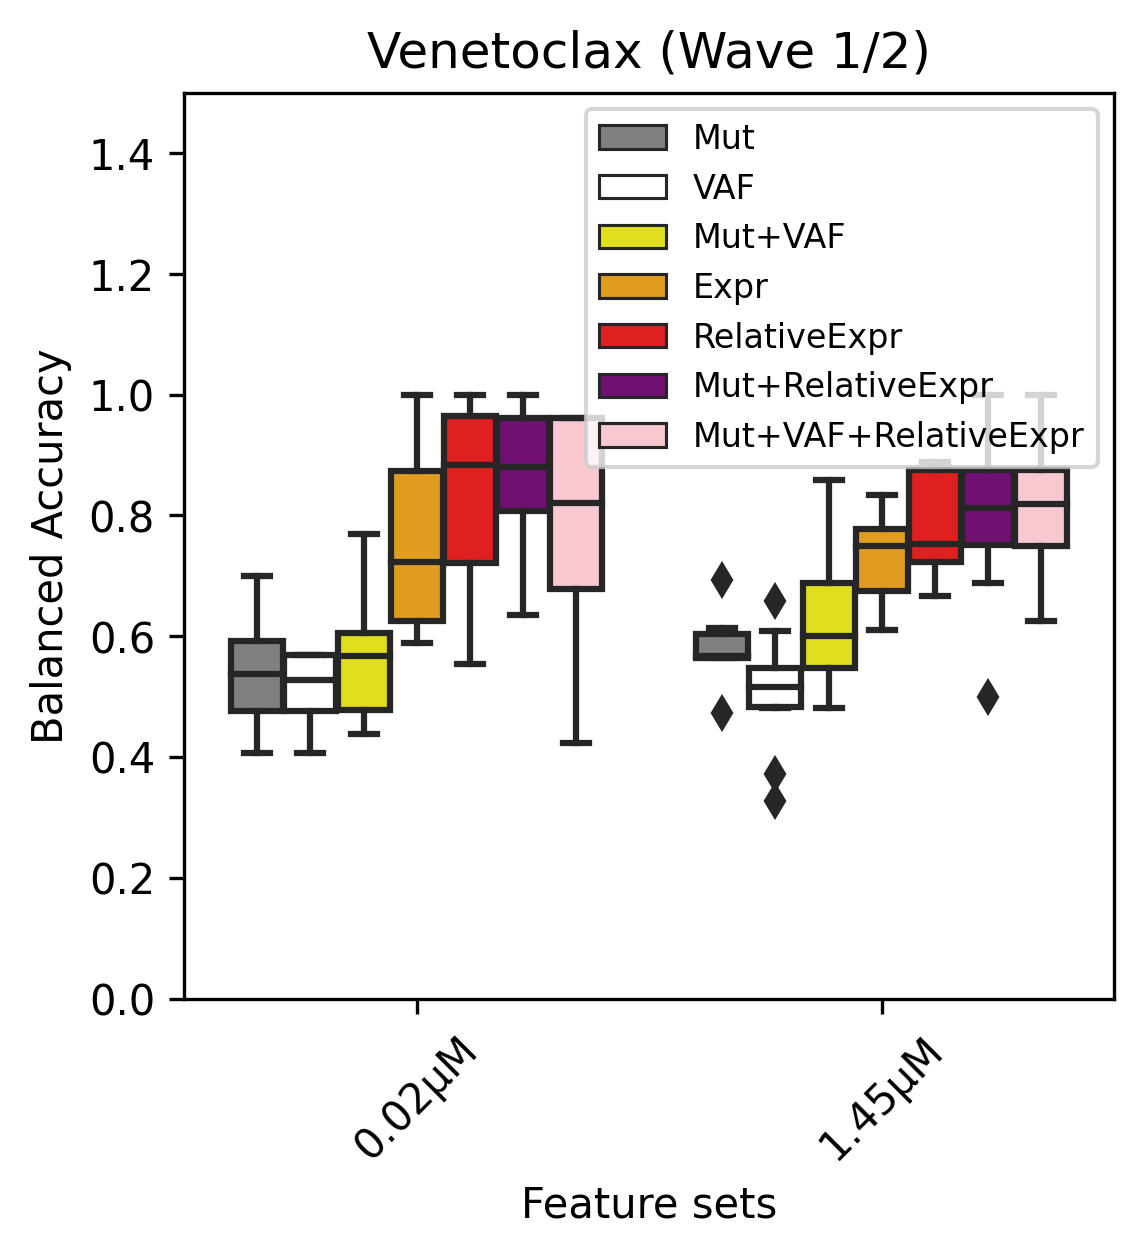

In [34]:
import seaborn as sns

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W1/2(Validation)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="Balanced_ACC",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
print(xticks_labels)
for i in range(0,len(xticks_labels)):
        xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "μM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.title(Drug.split("(")[0] +" (Wave 1/2)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)
# set legend font size
plt.legend(fontsize = 8)
plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")


plt.show()




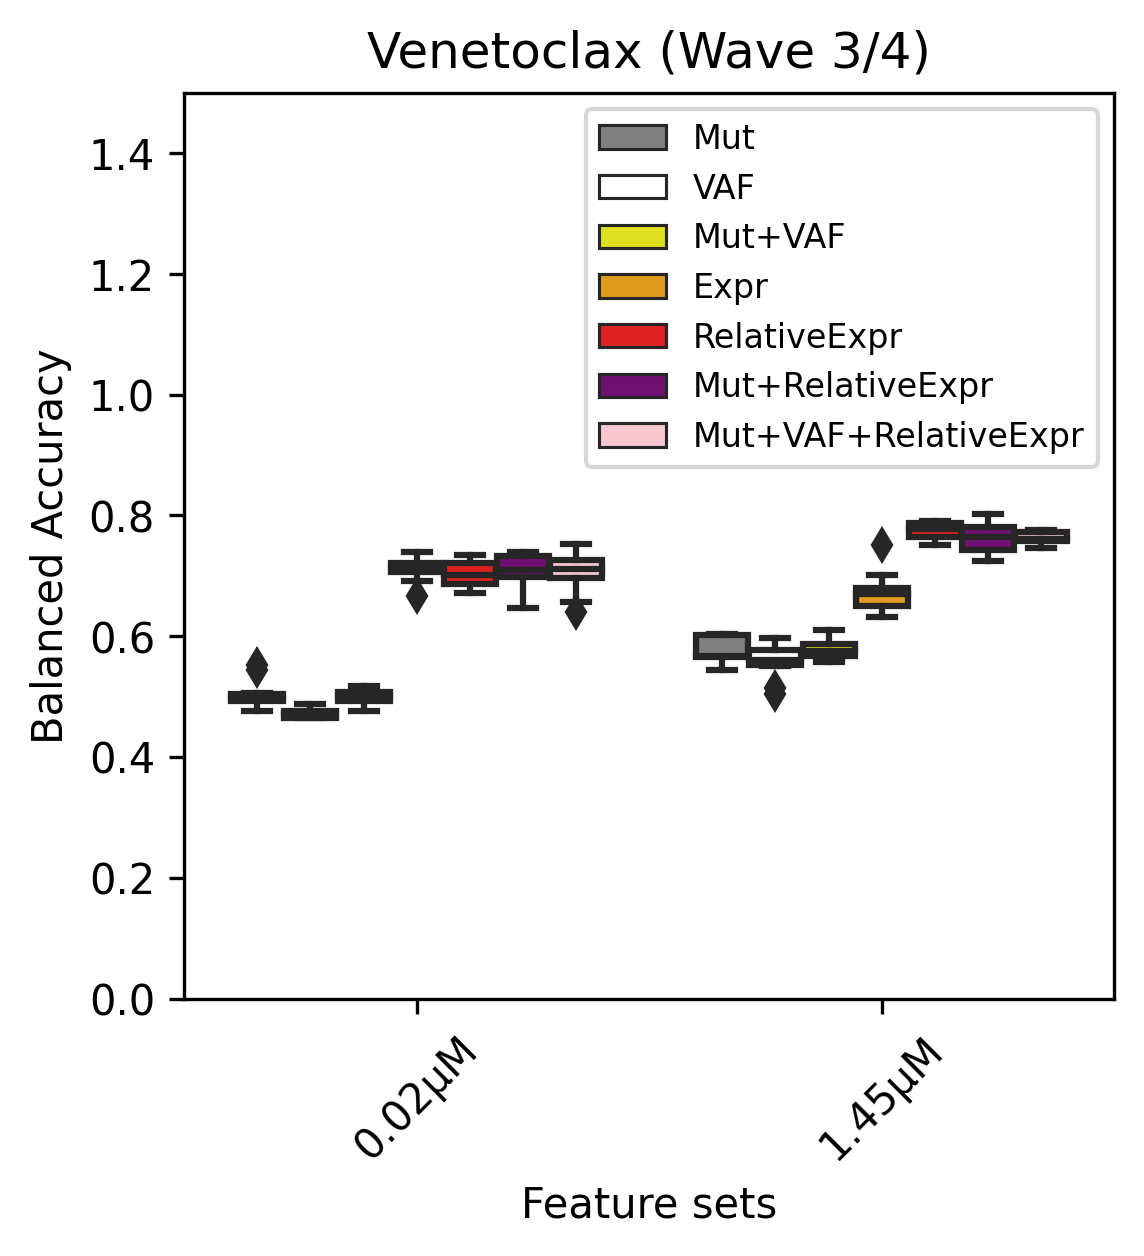

In [35]:

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W3/4(Test)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="Balanced_ACC",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
for i in range(0,len(xticks_labels)):
    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "μM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0]+" (Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]

plt.ylabel("Balanced Accuracy")
plt.xlabel("Feature sets")
plt.show()

In [36]:
# get the median value for each group in the result_df_cur_threshod dataframe

result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_21460/3277876921.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()


Balanced_ACC        F1
Threshold Feature_set                                 
0.019093  Expr                      0.713141  0.602326
          Mut                       0.497198  0.085145
          Mut+RelativeExpr          0.709128  0.596443
          Mut+VAF                   0.502665  0.187543
          Mut+VAF+RelativeExpr      0.711422  0.600055
          RelativeExpr              0.702260  0.581840
          VAF                       0.472389  0.042271
1.452619  Expr                      0.670693  0.776477
          Mut                       0.567603  0.585023
          Mut+RelativeExpr          0.764607  0.809518
          Mut+VAF                   0.575473  0.598000
          Mut+VAF+RelativeExpr      0.760761  0.804233
          RelativeExpr              0.777461  0.809169
          VAF                       0.561516  0.645045

[Text(0, 0, '0.0190925713799281'), Text(1, 0, '1.45261900330956')]


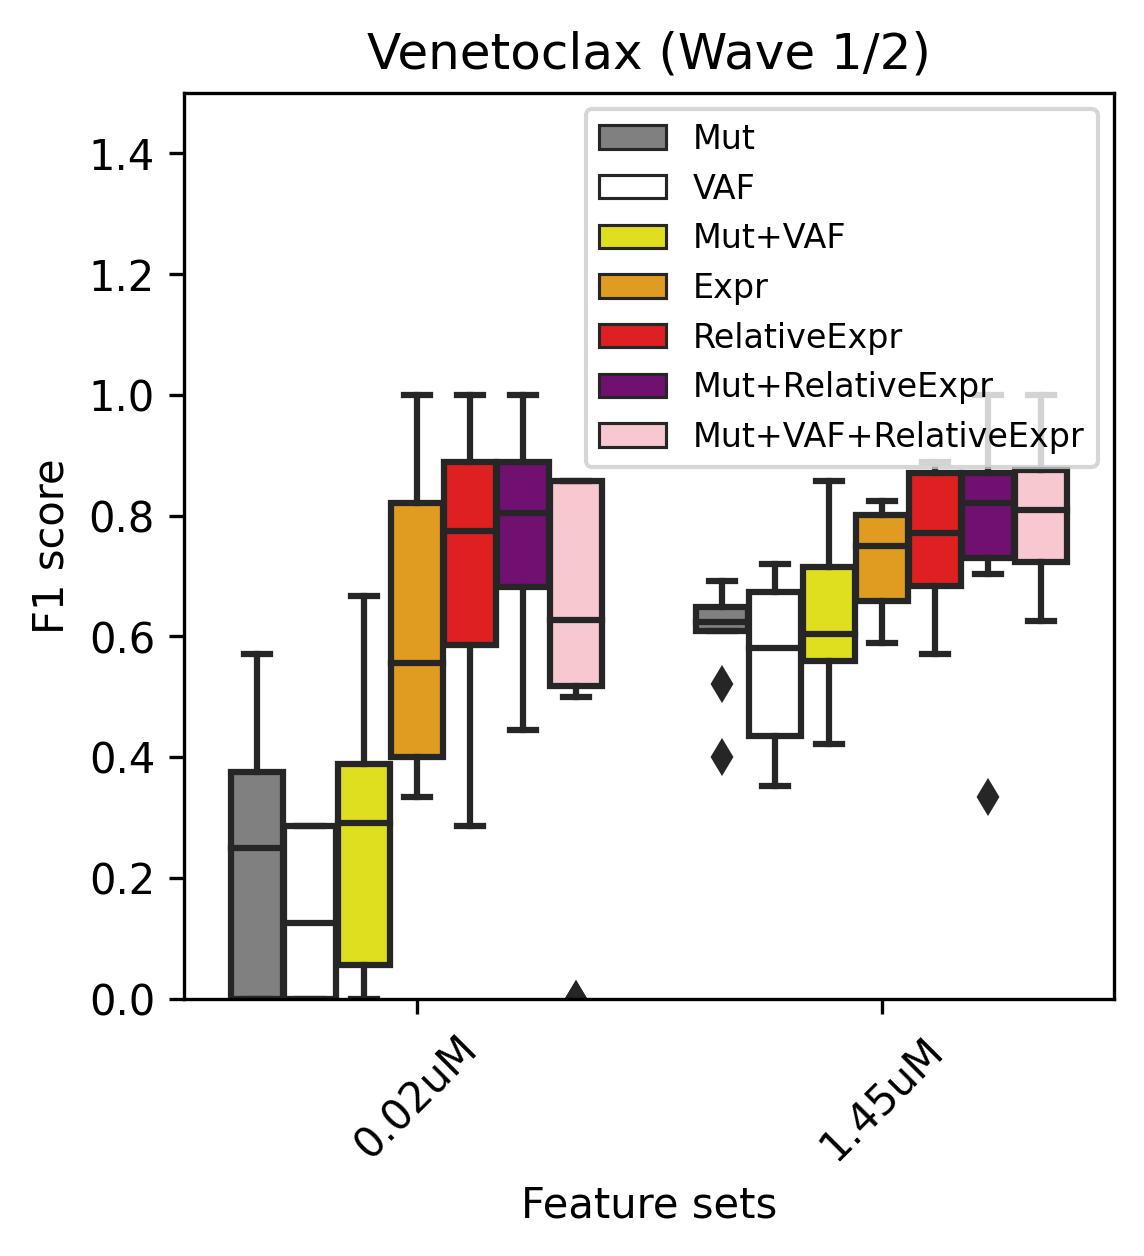

In [37]:
import seaborn as sns

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W1/2(Validation)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="F1",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
print(xticks_labels)
for i in range(0,len(xticks_labels)):
        xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0] +" (Wave 1/2)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

plt.ylabel("F1 score")
plt.xlabel("Feature sets")
plt.show()




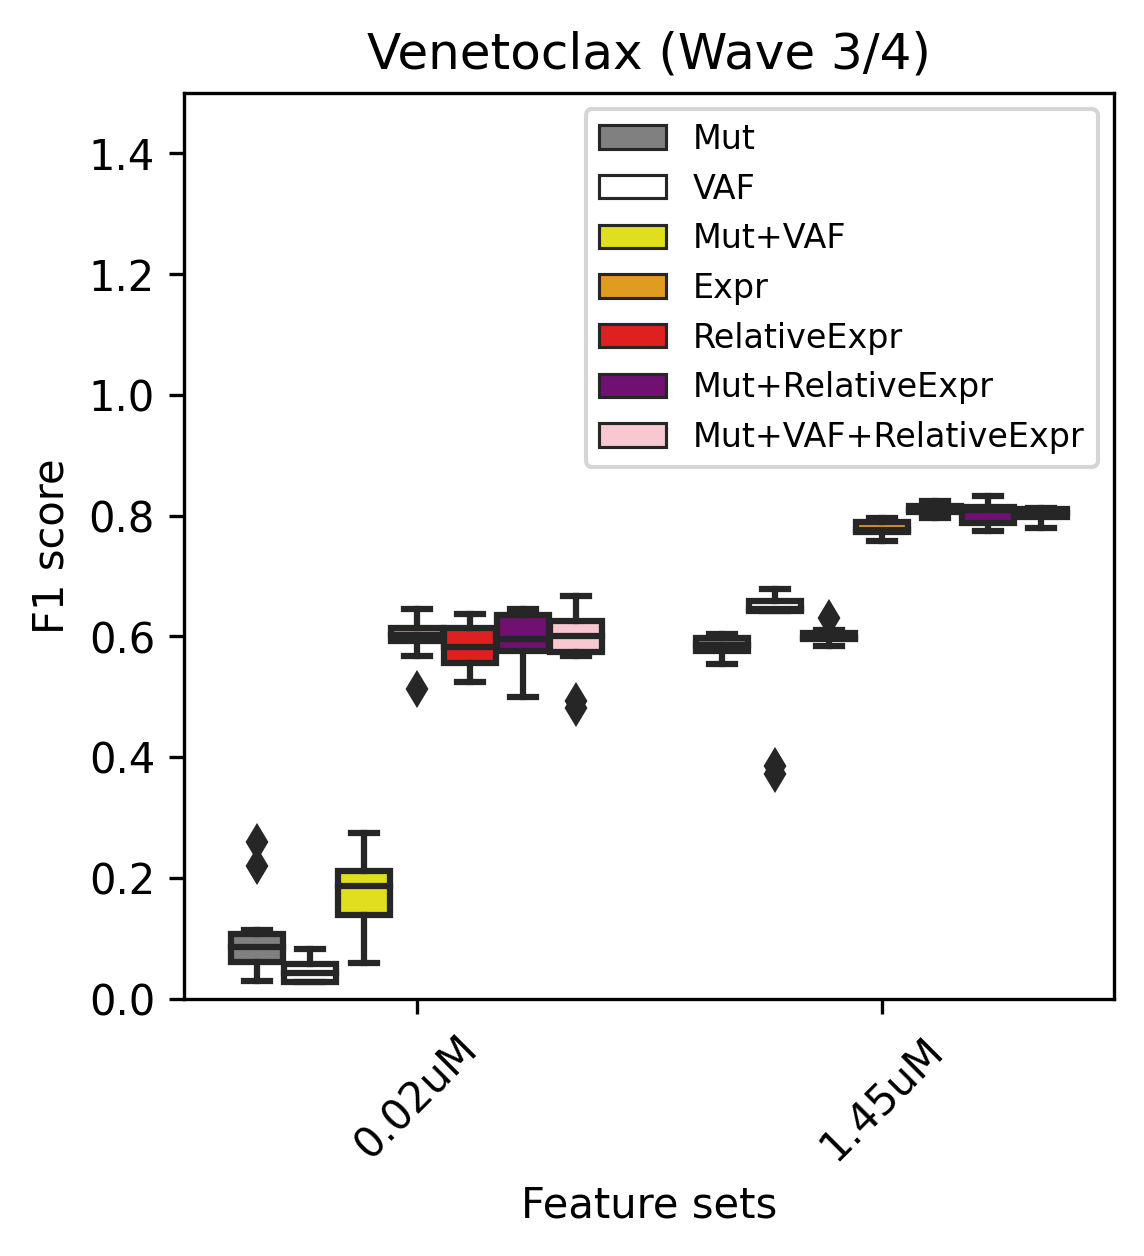

In [38]:

result_df_cur_threshod = result_df.loc[result_df['Dataset'] =="W3/4(Test)" ]

    #boxplot of result_df_cur_threshold grouped by feature_set
plt.figure(figsize = (4,4),dpi = 300)
sns.boxplot(x="Threshold", y="F1",
                hue="Feature_set", palette=["grey","white","yellow","orange" ,"red","purple","pink"],
                data=result_df_cur_threshod)
xticks_locs, xticks_labels = plt.xticks()
for i in range(0,len(xticks_labels)):
    xticks_labels[i] = str(round(float(xticks_labels[i].get_text()),2)) + "uM"

plt.xticks(xticks_locs, xticks_labels, rotation = 45)
plt.ylim(0,1.5)
plt.legend(fontsize = 8)
plt.title(Drug.split("(")[0]+" (Wave 3/4)" )
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    
plt.ylabel("F1 score")
plt.xlabel("Feature sets")
plt.show()

In [39]:
result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()

/var/folders/w1/p1v0w3j165ggfdk4xpn0tzgh0000gp/T/ipykernel_21460/3367169410.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  result_df_cur_threshod.groupby(["Threshold","Feature_set"]).median()


Balanced_ACC        F1
Threshold Feature_set                                 
0.019093  Expr                      0.713141  0.602326
          Mut                       0.497198  0.085145
          Mut+RelativeExpr          0.709128  0.596443
          Mut+VAF                   0.502665  0.187543
          Mut+VAF+RelativeExpr      0.711422  0.600055
          RelativeExpr              0.702260  0.581840
          VAF                       0.472389  0.042271
1.452619  Expr                      0.670693  0.776477
          Mut                       0.567603  0.585023
          Mut+RelativeExpr          0.764607  0.809518
          Mut+VAF                   0.575473  0.598000
          Mut+VAF+RelativeExpr      0.760761  0.804233
          RelativeExpr              0.777461  0.809169
          VAF                       0.561516  0.645045

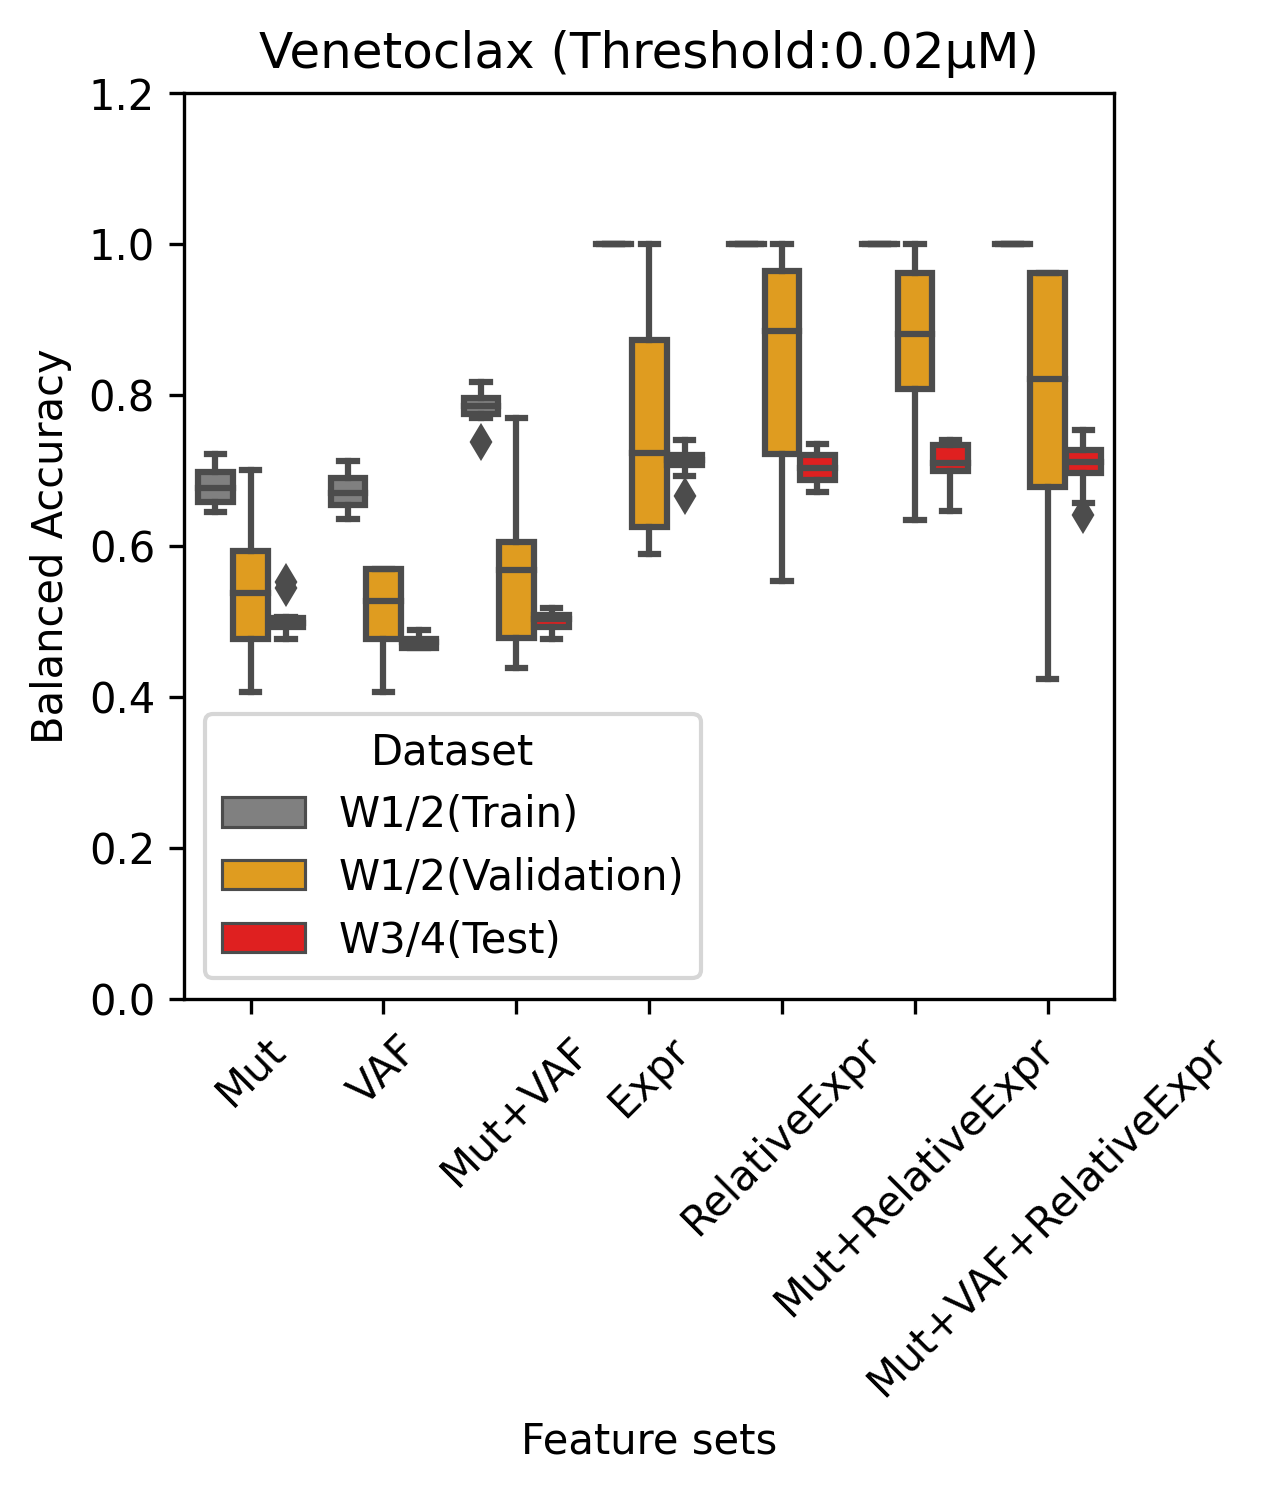

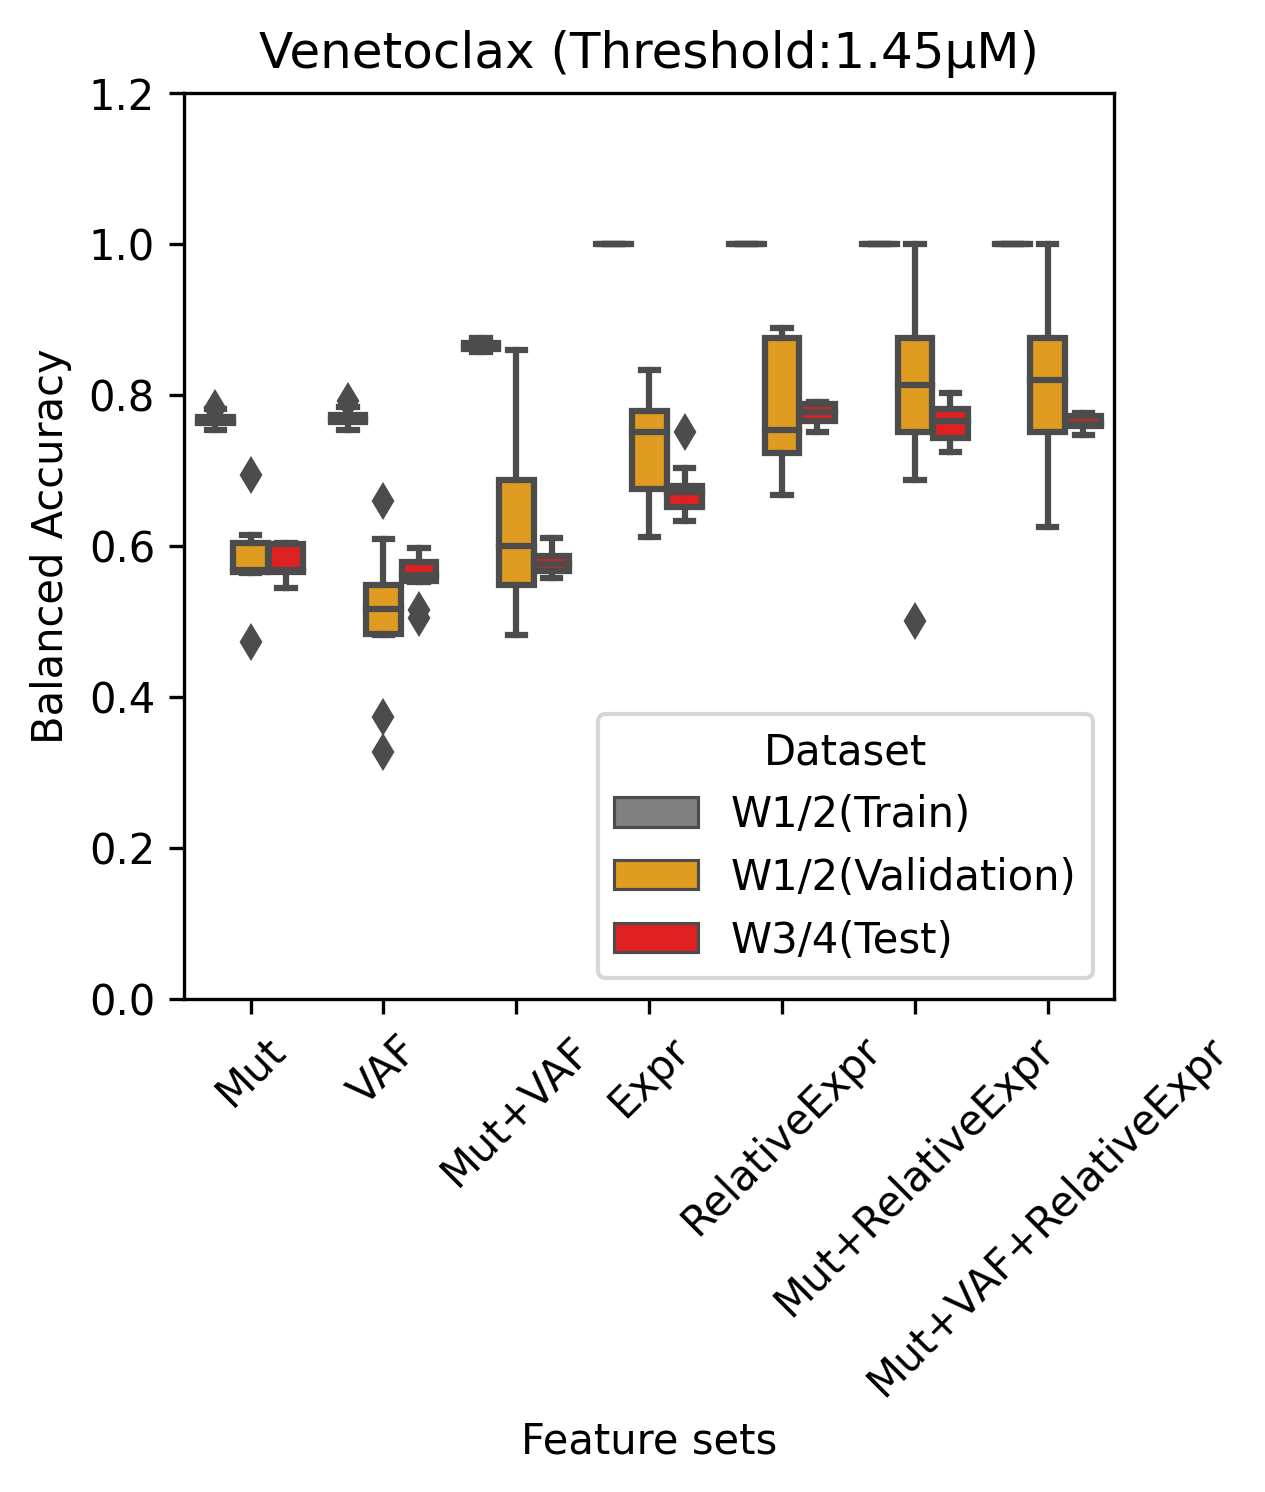

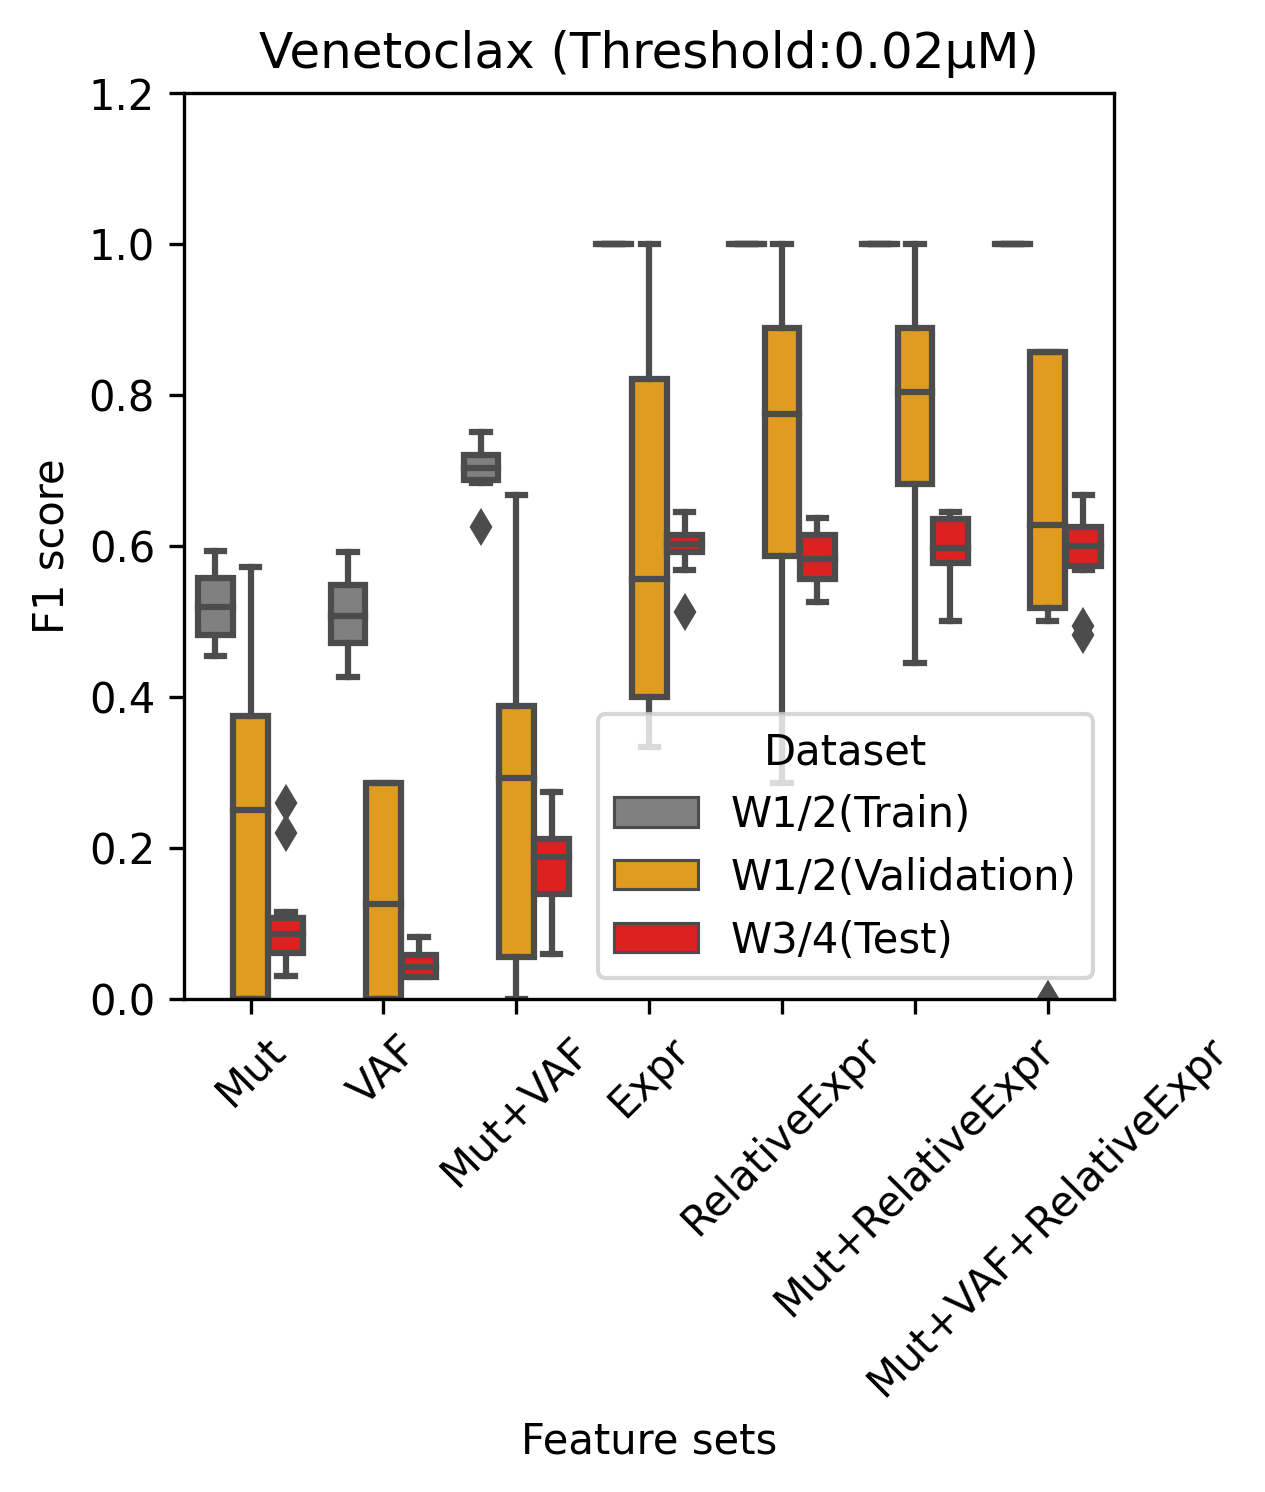

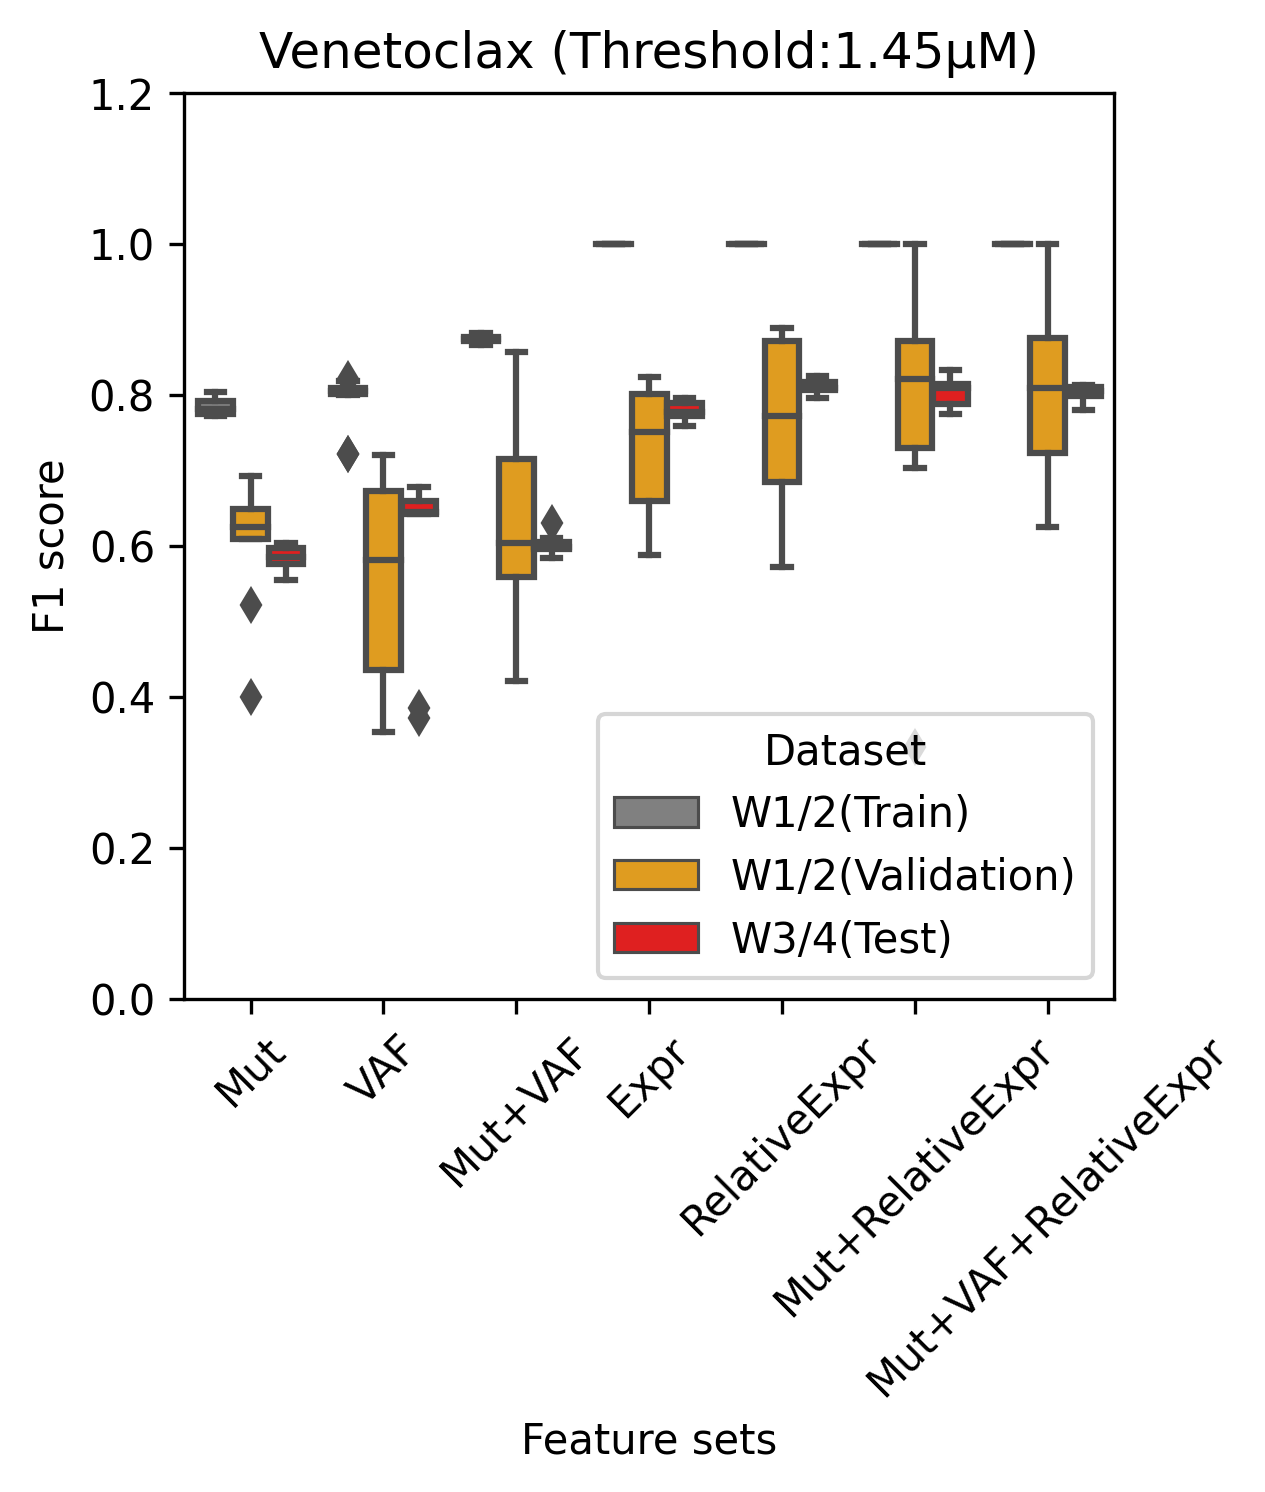

In [40]:
import seaborn as sns
for threshold in threshold_list:
    result_df_cur_threshod = result_df.loc[result_df['Threshold'] ==threshold ]

    #boxplot of result_df_cur_threshold grouped by feature_set
    plt.figure(figsize = (4,4),dpi = 300)
    sns.boxplot(x="Feature_set", y="Balanced_ACC",
                hue="Dataset", palette=["grey","orange" ,"red"],
                data=result_df_cur_threshod)
    
    plt.xticks(rotation = 45)
    plt.ylim(0,1.2)
    plt.title(Drug.split("(")[0] + " (Threshold:" + str(round(threshold,ndigits=2)) + "μM)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)

    plt.ylabel("Balanced Accuracy")
    plt.xlabel("Feature sets")
    plt.show()


for threshold in threshold_list:
    result_df_cur_threshod = result_df.loc[result_df['Threshold'] ==threshold ]

    #boxplot of result_df_cur_threshold grouped by feature_set
    plt.figure(figsize = (4,4),dpi = 300)
    sns.boxplot(x="Feature_set", y="F1",
                hue="Dataset", palette=["grey","orange","red"],
                data=result_df_cur_threshod)
    plt.xticks(rotation = 45)
    plt.ylim(0,1.2)
    plt.title(Drug.split("(")[0] + " (Threshold:" + str(round(threshold,ndigits=2)) + "μM)")
    #threshold_list_label = ["set1","set3","set4","set1&4"]
    #plt.xticks(range(0,len(threshold_list_label)), threshold_list_label, rotation = 90)
    plt.ylabel("F1 score")
    plt.xlabel("Feature sets")
    plt.show()



In [41]:
result_df.to_csv("../Data/Balanced_ACC_feature_sets_venetoclax.csv")

Mut Mut
Mut Expr
Mut RelativeExpr
Mut Mut+RelativeExpr
Expr Mut
Expr Expr
Expr RelativeExpr
Expr Mut+RelativeExpr
RelativeExpr Mut
RelativeExpr Expr
RelativeExpr RelativeExpr
RelativeExpr Mut+RelativeExpr
Mut+RelativeExpr Mut
Mut+RelativeExpr Expr
Mut+RelativeExpr RelativeExpr
Mut+RelativeExpr Mut+RelativeExpr


([<matplotlib.axis.YTick at 0x1452aee00>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'Expr'),
  Text(0, 2.5, 'RelativeExpr'),
  Text(0, 3.5, 'Mut+RelativeExpr')])

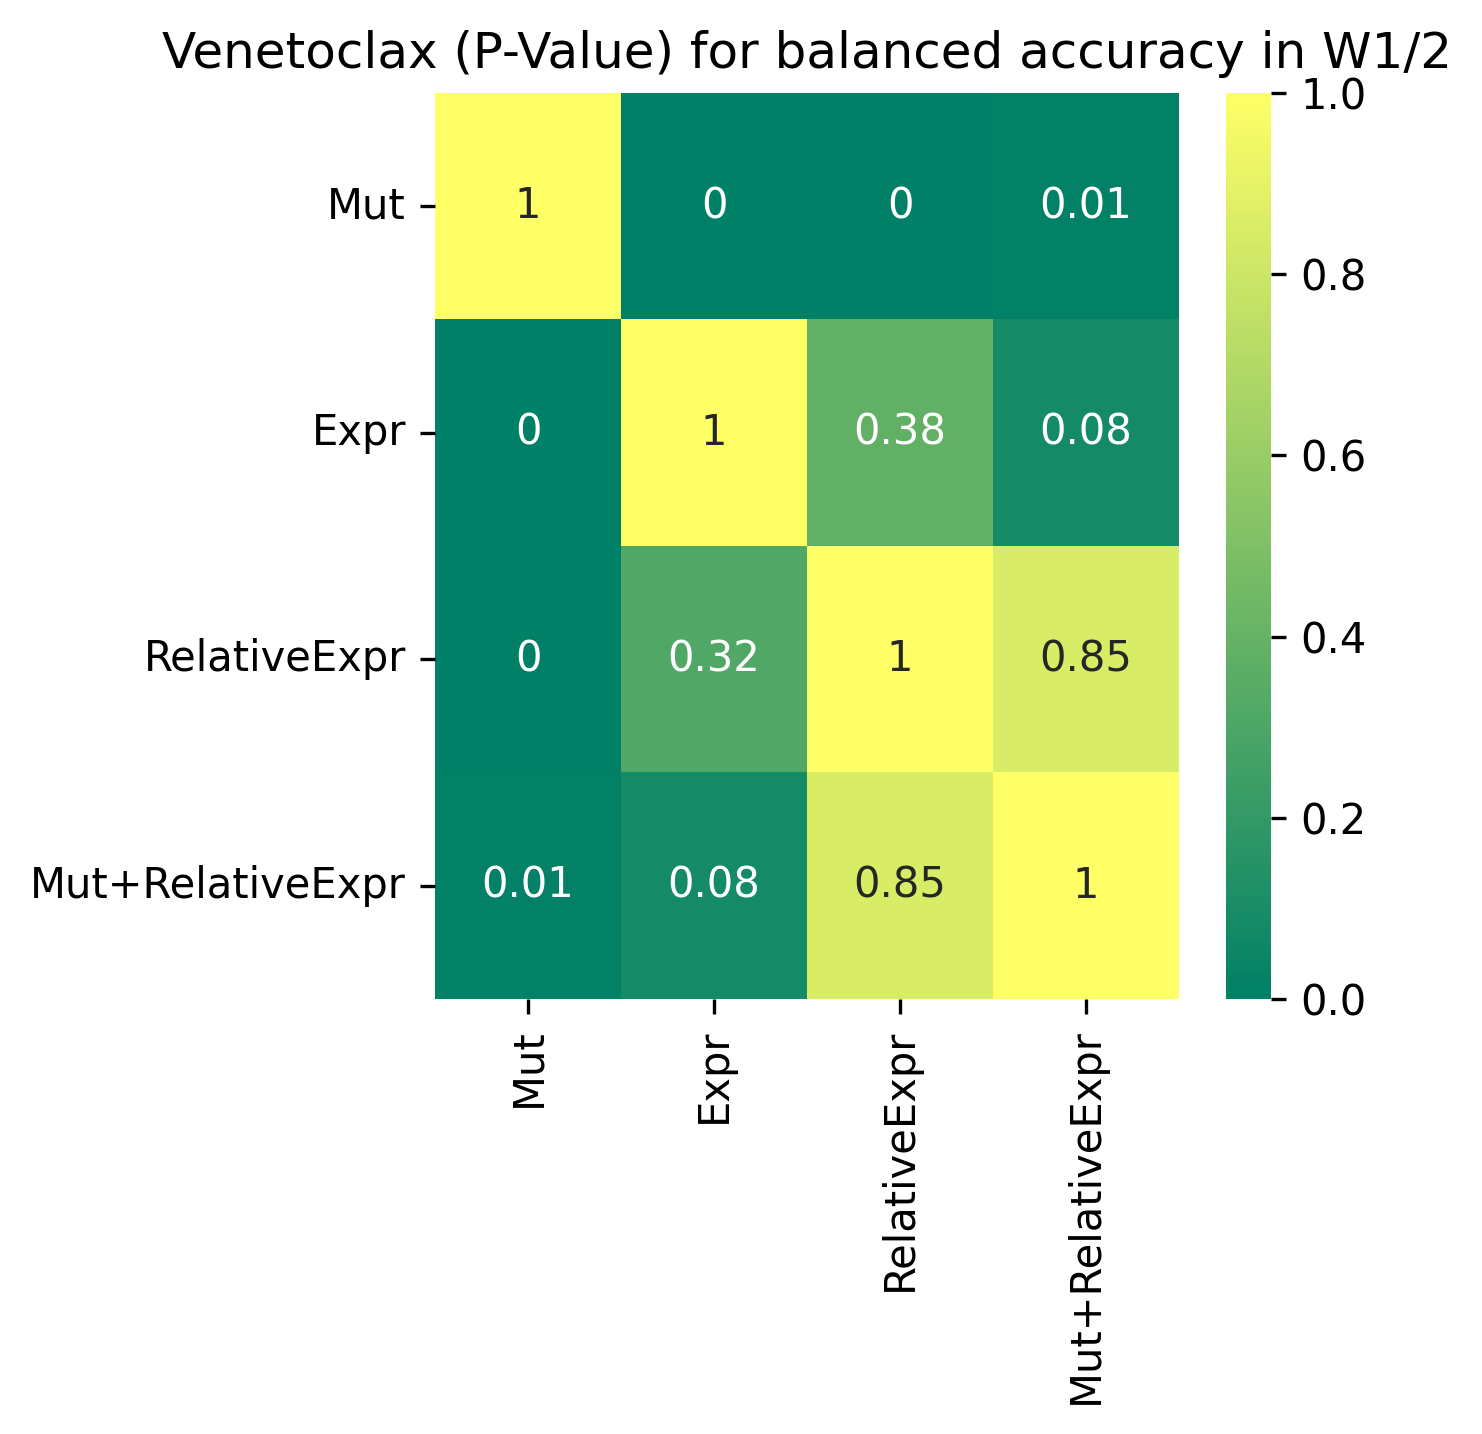

In [42]:

r_data = result_df.loc[result_df['Dataset'] == 'W1/2(Validation)']
r_data = r_data.loc[r_data['Threshold'] == 1.45261900330956	]
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        print(feature1, feature2)
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values  - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
            p = wilcoxon(d)[1]
        else:
            p = 1
        #p = ranksums(r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values, 
        #             r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for balanced accuracy in W1/2")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5], featureset, rotation = 0)
# set fontsize for the legend

([<matplotlib.axis.YTick at 0x140e12980>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'Expr'),
  Text(0, 2.5, 'RelativeExpr'),
  Text(0, 3.5, 'Mut+RelativeExpr')])

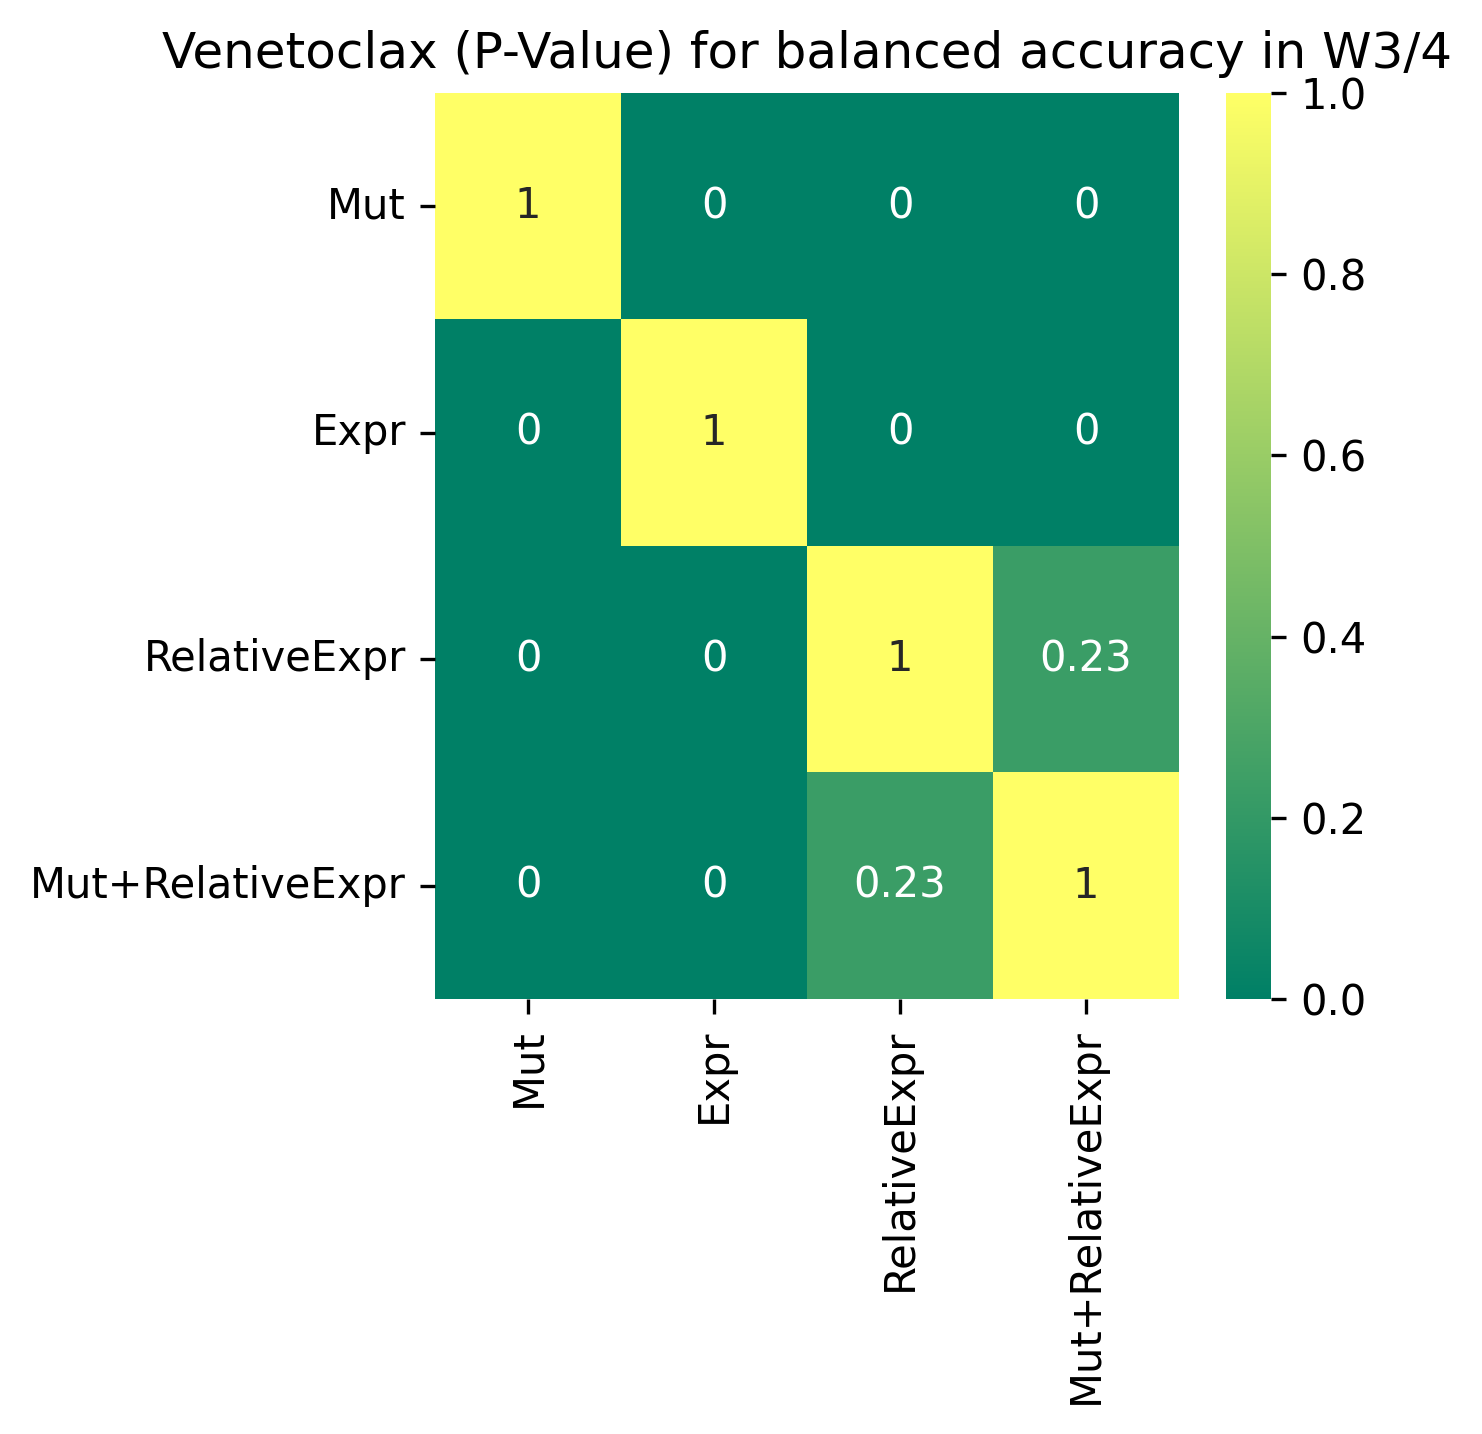

In [43]:
r_data = result_df.loc[result_df['Dataset'] == 'W3/4(Test)']
r_data = r_data.loc[r_data['Threshold'] == 1.45261900330956	]

# ranksum test
from scipy.stats import ranksums,wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
            p = wilcoxon(d)[1]
        else:
            p = 1

        #print(feature1, feature2)
        #d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
        #print(d)
        #p = wilcoxon(d)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for balanced accuracy in W3/4")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5], featureset, rotation = 0)
# set fontsize for the legend

([<matplotlib.axis.YTick at 0x141e2e4a0>,
 [Text(0, 0.5, 'Mut'),
  Text(0, 1.5, 'Expr'),
  Text(0, 2.5, 'RelativeExpr'),
  Text(0, 3.5, 'Mut+RelativeExpr')])

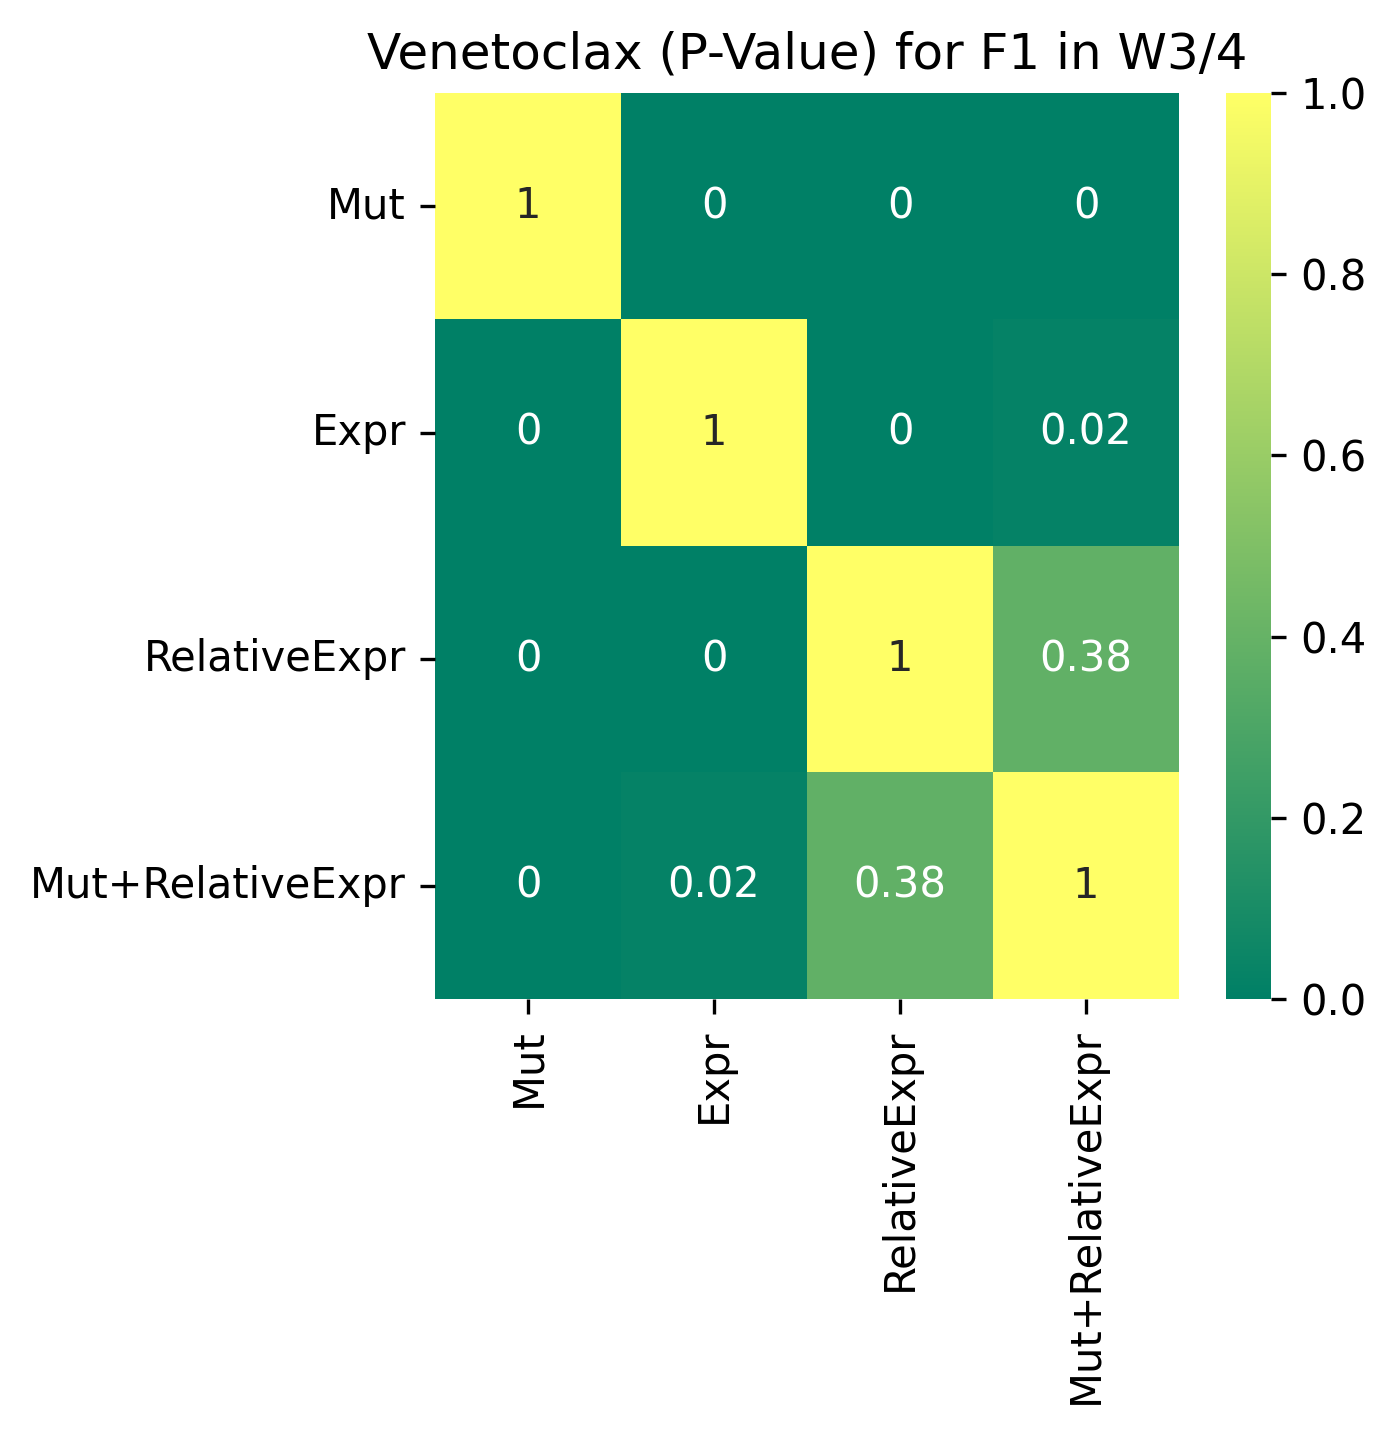

In [44]:
r_data = result_df.loc[result_df['Dataset'] == 'W3/4(Test)']
r_data = r_data.loc[r_data['Threshold'] == 1.45261900330956	]

# ranksum test
from scipy.stats import ranksums,wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []
for feature1 in featureset:
    p_list_cur = []
    for feature2 in featureset:
        if feature1 != feature2:
            d = r_data.loc[r_data['Feature_set'] == feature1]['F1'].values - r_data.loc[r_data['Feature_set'] == feature2]['F1'].values
            p = wilcoxon(d)[1]
        else:
            p = 1

        #print(feature1, feature2)
        #d = r_data.loc[r_data['Feature_set'] == feature1]['Balanced_ACC'].values - r_data.loc[r_data['Feature_set'] == feature2]['Balanced_ACC'].values
        #print(d)
        #p = wilcoxon(d)[1]
        p_list_cur.append(round(p,2))

    result_p[feature1] = p_list_cur


# heatmap plot for p value
plt.figure(figsize = (4,4),dpi = 300)
sns.heatmap(result_p, annot=True, cmap="summer")
plt.title(Drug + " (P-Value) for F1 in W3/4")
#plt.xticks([0.5,1.5,2.5,3.5,4,5,5.5], featureset, rotation = 90)
plt.yticks([0.5,1.5,2.5,3.5], featureset, rotation = 0)
# set fontsize for the legend

In [45]:
r_data = result_df.loc[result_df['Threshold'] == 1.45261900330956]

# compare groups between w1/2 and w3/4 
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []

p_list_cur = []
for feature1 in featureset:
    print(feature1)
    cur_df = r_data.loc[r_data['Feature_set'] == feature1]
    d = cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['Balanced_ACC'].values - cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values
    p = ranksums(cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['Balanced_ACC'].values, 
                 cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['Balanced_ACC'].values)[1]
    print("ranksums")
    print(p)
    print("wilcoxon")
    p = wilcoxon(d)[1]
    print(p)
    p_list_cur.append(p)

print("P values between W1/2 and W3/4")
print(p_list_cur)

Mut
ranksums
0.7054569861112734
wilcoxon
0.76953125
Expr
ranksums
0.0493661947519327
wilcoxon
0.10546875
RelativeExpr
ranksums
0.7623688184698398
wilcoxon
0.845703125
Mut+RelativeExpr
ranksums
0.09630369202868826
wilcoxon
0.322265625
P values between W1/2 and W3/4
[0.76953125, 0.10546875, 0.845703125, 0.322265625]


In [46]:
r_data = result_df.loc[result_df['Threshold'] == 1.45261900330956]

# compare groups between w1/2 and w3/4 
# ranksum test
from scipy.stats import ranksums, wilcoxon
featureset = [ 'Mut', 'Expr', 'RelativeExpr', 'Mut+RelativeExpr']

result_p = pd.DataFrame()
row_list = []

p_list_cur = []
for feature1 in featureset:
    print(feature1)
    
    cur_df = r_data.loc[r_data['Feature_set'] == feature1]
    d = cur_df.loc[cur_df['Dataset'] == 'W3/4(Test)']['F1'].values - cur_df.loc[cur_df['Dataset'] == 'W1/2(Validation)']['F1'].values
    p = wilcoxon(d)[1]
    print(p)
    p_list_cur.append(p)

print("P values between W1/2 and W3/4")
print(p_list_cur)

Mut
0.375
Expr
0.16015625
RelativeExpr
0.431640625
Mut+RelativeExpr
1.0
P values between W1/2 and W3/4
[0.375, 0.16015625, 0.431640625, 1.0]


In [40]:
result_with_threshod.keys()

dict_keys([0.0190925713799281, 1.45261900330956])

(211, 8)


Text(0, 0.5, 'Feature importance (Mut+VAF+RelativeExpr)')

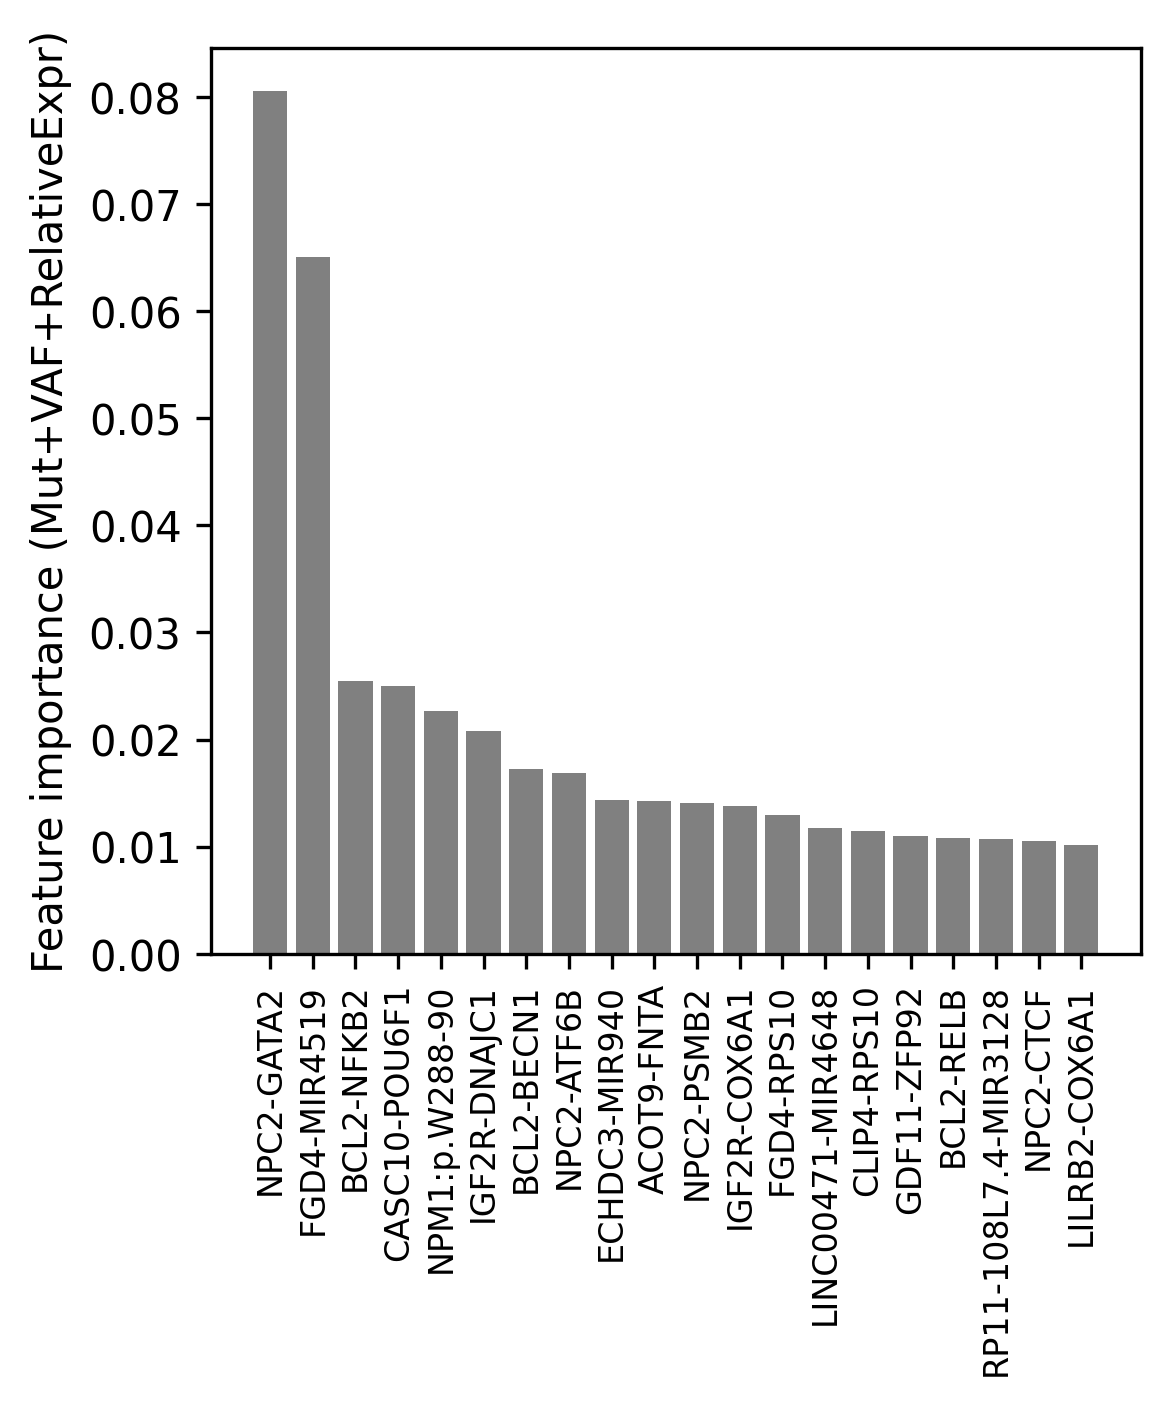

In [48]:

feature_IMP =pd.DataFrame()
Threshold = 1.45261900330956
#featureset_cur = "RelativeExpr"
#featureset_cur = "Expr"
featureset_cur = "Mut+VAF+RelativeExpr"
#featureset_cur = "Mut"

for random_state in result_with_threshod[Threshold][featureset_cur]:
    if result_with_threshod[Threshold][featureset_cur][random_state]['balanced_acc'] > 0.7:
        features = result_with_threshod[Threshold][featureset_cur][random_state]['features']['Feature'].values
        IMP = result_with_threshod[Threshold][featureset_cur][random_state]['features']['IMP'].values
        cur_df = pd.DataFrame({"IMP" + str(random_state): IMP})
        cur_df.index = features
        feature_IMP = pd.concat([feature_IMP,cur_df ],axis =1)
print(feature_IMP.shape)
IMP_sum = feature_IMP.transpose().sum()/feature_IMP.transpose().shape[0]
x_feature = pd.DataFrame({"Feature":IMP_sum.index, "IMP":IMP_sum.values})
x_feature_sorted = x_feature.sort_values(by = ["IMP"], ascending = False).head(20)

plt.figure(figsize = (4,4),dpi = 300)
plt.bar(np.arange(0,x_feature_sorted.shape[0], 1), x_feature_sorted['IMP'], width=0.8,  color = 'grey',
        bottom=None,  align='center')
#plt.ylabel("correlation coeffient")

xticks_new = []
for i in x_feature_sorted['Feature']:
    
    if i.startswith("ENSG") and i in dic_gene_map:
        xticks_new.append(dic_gene_map[i])
    else: 
        xticks_new.append(i)


plt.xticks(np.arange(0,x_feature_sorted.shape[0], 1),xticks_new , rotation = 90, fontsize =8)
plt.ylabel("Feature importance (" + featureset_cur + ")")


